# **Efficient Checkpointing on LeNet** 

Let's compare these 3 approaches : 
1. **Initial accuracy measurement:** Train LeNet on MNIST and achieve a baseline accuracy of around 99.9% without considering poisoned models.
2. **Incremental learning:** Implement incremental learning on the divided MNIST subsets and measure the accuracy drop due to this method.
3. **LC-checkpoint and Delta LoRA:** Apply LC-checkpoint and Delta LoRA on top of incremental learning and observe the resulting accuracy.

---

## **Importing Libraries**

In [1]:
import glob
import sys
import os
import shutil
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import scipy as spy
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
import ssl
import pickle, json
import src.main as lc
import old_lc.main as olc
from src.models.LeNet import LeNet
import src.compression.deltaCompress as lc_compress
from src.models.LeNet_LowRank import getBase, LeNet_LowRank, load_sd_decomp
from src.utils.utils import evaluate_accuracy, evaluate_accuracy_gpu, lazy_restore,lazy_restore_gpu, evaluate_compression

c:\Users\Bradf\anaconda3\envs\py310\lib\site-packages\transformers\utils\generic.py:485: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


## **Connexion to wandb**

In [2]:
import wandb
# Connect to W&B
wandb.login(key="beb938fdf67db528128a4298e19b9997afd83dfd")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bryanchen1105 (bryanbradfo). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Bradf\.netrc


True

## **Variables and Constants**

In [3]:
train_batch_size = 64
test_batch_size = 1000
num_work = 14

## **Load MNIST dataset**

In [4]:
def data_loader():

    transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize(0.1307, 0.3081)
    ])

    trainset = datasets.MNIST(root='./data', train=True,
                                          download=True, transform=transform)

    trainset.data = trainset.data.clone()[:]
    trainset.targets = trainset.targets.clone()[:]
    trainloader = torch.utils.data.DataLoader(trainset, batch_size = train_batch_size,
                                              shuffle=True, num_workers=num_work)

    testset = datasets.MNIST(root='./data', train=False,
                                         download=True, transform=transform)

    testset.data = testset.data.clone()[:]
    testset.targets = testset.targets.clone()[:]
    testloader = torch.utils.data.DataLoader(testset, batch_size = test_batch_size,
                                             shuffle=False, num_workers=num_work)
    
    return trainloader, testloader

In [5]:
# Bypass using SSL unverified
ssl._create_default_https_context = ssl._create_unverified_context
# MNIST dataset 
train_loader, test_loader = data_loader()

### **Bypass the matplotlib error**

In [6]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

### **Verify if data loaded correctly**

#### **Verify the 10 classes of training dataset and 10 classes of testing dataset**

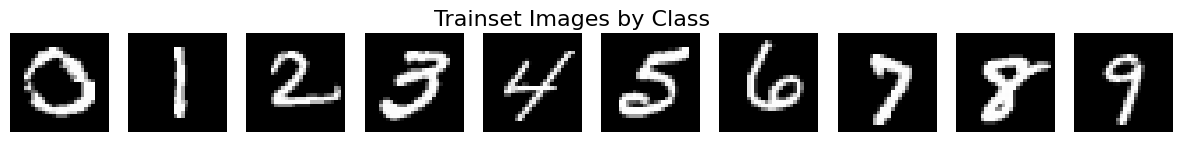

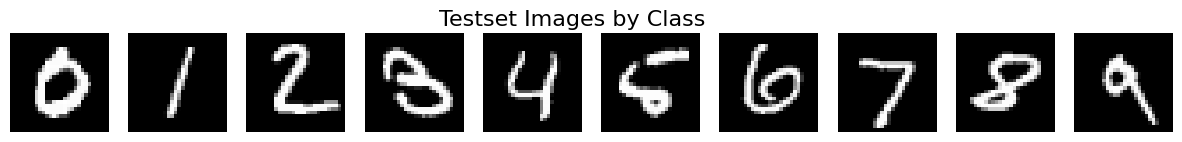

In [6]:
# Going through the dataloader to extract an image per class
def get_images_by_class(dataloader):
    images_by_class = {i: None for i in range(10)}
    for images, labels in dataloader:
        for i in range(len(labels)):
            label = labels[i].item()
            if images_by_class[label] is None:
                images_by_class[label] = images[i]
            if all(v is not None for v in images_by_class.values()):
                return images_by_class
    return images_by_class

def plot_images(images_by_class, title):
    fig, axes = plt.subplots(1, 10, figsize=(15, 1.5))
    fig.suptitle(title, fontsize=16)
    for i in range(10):
        ax = axes[i]
        ax.imshow(images_by_class[i].squeeze(), cmap='gray')
        ax.axis('off')
    plt.show()


train_images = get_images_by_class(train_loader)
test_images = get_images_by_class(test_loader)

plot_images(train_images, "Trainset Images by Class")
plot_images(test_images, "Testset Images by Class")

#### **Verify that the 10 first images are visually different**

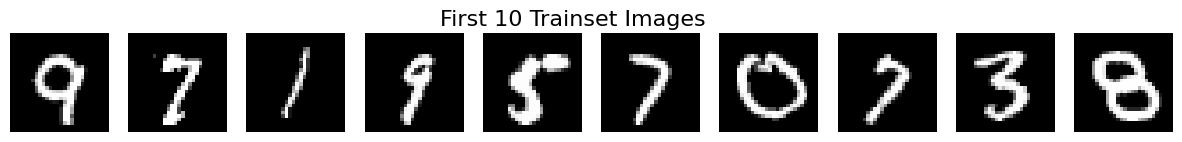

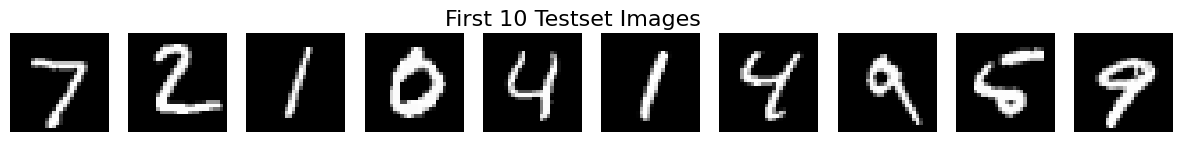

In [7]:
def plot_first_images(dataloader, title, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 1.5))
    fig.suptitle(title, fontsize=16)
    
    images_shown = 0
    for images, labels in dataloader:
        for i in range(len(images)):
            if images_shown >= num_images:
                break
            ax = axes[images_shown]
            ax.imshow(images[i].squeeze(), cmap='gray')
            ax.axis('off')
            images_shown += 1
        if images_shown >= num_images:
            break

    plt.show()

plot_first_images(train_loader, "First 10 Trainset Images")
plot_first_images(test_loader, "First 10 Testset Images")

### **Splitting the dataset into three subsets having each all classes**

In [7]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np

def stratified_split(dataset, proportions):
    class_indices = [np.where(np.array(dataset.targets) == i)[0] for i in range(80)]
    
    split_indices = []
    for proportion in proportions:
        class_split_indices = [np.split(indices, [int(proportion[0]*len(indices)),
int((proportion[0]+proportion[1])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9])*len(indices)),
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19])*len(indices)),
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29])*len(indices)),
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32]+proportion[33])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32]+proportion[33]+proportion[34])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32]+proportion[33]+proportion[34]+proportion[35])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32]+proportion[33]+proportion[34]+proportion[35]+proportion[36])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32]+proportion[33]+proportion[34]+proportion[35]+proportion[36]+proportion[37])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32]+proportion[33]+proportion[34]+proportion[35]+proportion[36]+proportion[37]+proportion[38])*len(indices)), 
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32]+proportion[33]+proportion[34]+proportion[35]+proportion[36]+proportion[37]+proportion[38]+proportion[39])*len(indices)),
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32]+proportion[33]+proportion[34]+proportion[35]+proportion[36]+proportion[37]+proportion[38]+proportion[39]+proportion[40])*len(indices)),
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32]+proportion[33]+proportion[34]+proportion[35]+proportion[36]+proportion[37]+proportion[38]+proportion[39]+proportion[40]
     +proportion[41])*len(indices)),
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32]+proportion[33]+proportion[34]+proportion[35]+proportion[36]+proportion[37]+proportion[38]+proportion[39]+proportion[40]
     +proportion[41]+proportion[42])*len(indices)),
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32]+proportion[33]+proportion[34]+proportion[35]+proportion[36]+proportion[37]+proportion[38]+proportion[39]+proportion[40]
     +proportion[41]+proportion[42]+proportion[43])*len(indices)),
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32]+proportion[33]+proportion[34]+proportion[35]+proportion[36]+proportion[37]+proportion[38]+proportion[39]+proportion[40]
     +proportion[41]+proportion[42]+proportion[43]+proportion[44])*len(indices)),
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32]+proportion[33]+proportion[34]+proportion[35]+proportion[36]+proportion[37]+proportion[38]+proportion[39]+proportion[40]
     +proportion[41]+proportion[42]+proportion[43]+proportion[44]+proportion[45])*len(indices)),
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32]+proportion[33]+proportion[34]+proportion[35]+proportion[36]+proportion[37]+proportion[38]+proportion[39]+proportion[40]
     +proportion[41]+proportion[42]+proportion[43]+proportion[44]+proportion[45]+proportion[46])*len(indices)),
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32]+proportion[33]+proportion[34]+proportion[35]+proportion[36]+proportion[37]+proportion[38]+proportion[39]+proportion[40]
     +proportion[41]+proportion[42]+proportion[43]+proportion[44]+proportion[45]+proportion[46]+proportion[47])*len(indices)),
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32]+proportion[33]+proportion[34]+proportion[35]+proportion[36]+proportion[37]+proportion[38]+proportion[39]+proportion[40]
     +proportion[41]+proportion[42]+proportion[43]+proportion[44]+proportion[45]+proportion[46]+proportion[47]+proportion[48])*len(indices)),
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32]+proportion[33]+proportion[34]+proportion[35]+proportion[36]+proportion[37]+proportion[38]+proportion[39]+proportion[40]
     +proportion[41]+proportion[42]+proportion[43]+proportion[44]+proportion[45]+proportion[46]+proportion[47]+proportion[48]+proportion[49])*len(indices)),
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32]+proportion[33]+proportion[34]+proportion[35]+proportion[36]+proportion[37]+proportion[38]+proportion[39]+proportion[40]
     +proportion[41]+proportion[42]+proportion[43]+proportion[44]+proportion[45]+proportion[46]+proportion[47]+proportion[48]+proportion[49]+proportion[50])*len(indices)),
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32]+proportion[33]+proportion[34]+proportion[35]+proportion[36]+proportion[37]+proportion[38]+proportion[39]+proportion[40]
     +proportion[41]+proportion[42]+proportion[43]+proportion[44]+proportion[45]+proportion[46]+proportion[47]+proportion[48]+proportion[49]+proportion[50]+proportion[51])*len(indices)),
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32]+proportion[33]+proportion[34]+proportion[35]+proportion[36]+proportion[37]+proportion[38]+proportion[39]+proportion[40]
     +proportion[41]+proportion[42]+proportion[43]+proportion[44]+proportion[45]+proportion[46]+proportion[47]+proportion[48]+proportion[49]+proportion[50]+proportion[51]+proportion[52])*len(indices)),
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32]+proportion[33]+proportion[34]+proportion[35]+proportion[36]+proportion[37]+proportion[38]+proportion[39]+proportion[40]
     +proportion[41]+proportion[42]+proportion[43]+proportion[44]+proportion[45]+proportion[46]+proportion[47]+proportion[48]+proportion[49]+proportion[50]+proportion[51]+proportion[52]+proportion[53])*len(indices)),
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32]+proportion[33]+proportion[34]+proportion[35]+proportion[36]+proportion[37]+proportion[38]+proportion[39]+proportion[40]
     +proportion[41]+proportion[42]+proportion[43]+proportion[44]+proportion[45]+proportion[46]+proportion[47]+proportion[48]+proportion[49]+proportion[50]+proportion[51]+proportion[52]+proportion[53]+proportion[54])*len(indices)),
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32]+proportion[33]+proportion[34]+proportion[35]+proportion[36]+proportion[37]+proportion[38]+proportion[39]+proportion[40]
     +proportion[41]+proportion[42]+proportion[43]+proportion[44]+proportion[45]+proportion[46]+proportion[47]+proportion[48]+proportion[49]+proportion[50]+proportion[51]+proportion[52]+proportion[53]+proportion[54]+proportion[55])*len(indices)),
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32]+proportion[33]+proportion[34]+proportion[35]+proportion[36]+proportion[37]+proportion[38]+proportion[39]+proportion[40]
     +proportion[41]+proportion[42]+proportion[43]+proportion[44]+proportion[45]+proportion[46]+proportion[47]+proportion[48]+proportion[49]+proportion[50]+proportion[51]+proportion[52]+proportion[53]+proportion[54]+proportion[55]+proportion[56])*len(indices)),
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32]+proportion[33]+proportion[34]+proportion[35]+proportion[36]+proportion[37]+proportion[38]+proportion[39]+proportion[40]
     +proportion[41]+proportion[42]+proportion[43]+proportion[44]+proportion[45]+proportion[46]+proportion[47]+proportion[48]+proportion[49]+proportion[50]+proportion[51]+proportion[52]+proportion[53]+proportion[54]+proportion[55]+proportion[56]+proportion[57])*len(indices)),
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32]+proportion[33]+proportion[34]+proportion[35]+proportion[36]+proportion[37]+proportion[38]+proportion[39]+proportion[40]
     +proportion[41]+proportion[42]+proportion[43]+proportion[44]+proportion[45]+proportion[46]+proportion[47]+proportion[48]+proportion[49]+proportion[50]+proportion[51]+proportion[52]+proportion[53]+proportion[54]+proportion[55]+proportion[56]+proportion[57]+proportion[58])*len(indices)),
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32]+proportion[33]+proportion[34]+proportion[35]+proportion[36]+proportion[37]+proportion[38]+proportion[39]+proportion[40]
     +proportion[41]+proportion[42]+proportion[43]+proportion[44]+proportion[45]+proportion[46]+proportion[47]+proportion[48]+proportion[49]+proportion[50]+proportion[51]+proportion[52]+proportion[53]+proportion[54]+proportion[55]+proportion[56]+proportion[57]+proportion[58]+proportion[59])*len(indices)),
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32]+proportion[33]+proportion[34]+proportion[35]+proportion[36]+proportion[37]+proportion[38]+proportion[39]+proportion[40]
     +proportion[41]+proportion[42]+proportion[43]+proportion[44]+proportion[45]+proportion[46]+proportion[47]+proportion[48]+proportion[49]+proportion[50]+proportion[51]+proportion[52]+proportion[53]+proportion[54]+proportion[55]+proportion[56]+proportion[57]+proportion[58]+proportion[59]+proportion[60])*len(indices)),
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32]+proportion[33]+proportion[34]+proportion[35]+proportion[36]+proportion[37]+proportion[38]+proportion[39]+proportion[40]
     +proportion[41]+proportion[42]+proportion[43]+proportion[44]+proportion[45]+proportion[46]+proportion[47]+proportion[48]+proportion[49]+proportion[50]+proportion[51]+proportion[52]+proportion[53]+proportion[54]+proportion[55]+proportion[56]+proportion[57]+proportion[58]+proportion[59]+proportion[60]
     +proportion[61])*len(indices)),
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32]+proportion[33]+proportion[34]+proportion[35]+proportion[36]+proportion[37]+proportion[38]+proportion[39]+proportion[40]
     +proportion[41]+proportion[42]+proportion[43]+proportion[44]+proportion[45]+proportion[46]+proportion[47]+proportion[48]+proportion[49]+proportion[50]+proportion[51]+proportion[52]+proportion[53]+proportion[54]+proportion[55]+proportion[56]+proportion[57]+proportion[58]+proportion[59]+proportion[60]
     +proportion[61]+proportion[62])*len(indices)),
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32]+proportion[33]+proportion[34]+proportion[35]+proportion[36]+proportion[37]+proportion[38]+proportion[39]+proportion[40]
     +proportion[41]+proportion[42]+proportion[43]+proportion[44]+proportion[45]+proportion[46]+proportion[47]+proportion[48]+proportion[49]+proportion[50]+proportion[51]+proportion[52]+proportion[53]+proportion[54]+proportion[55]+proportion[56]+proportion[57]+proportion[58]+proportion[59]+proportion[60]
     +proportion[61]+proportion[62]+proportion[63])*len(indices)),
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32]+proportion[33]+proportion[34]+proportion[35]+proportion[36]+proportion[37]+proportion[38]+proportion[39]+proportion[40]
     +proportion[41]+proportion[42]+proportion[43]+proportion[44]+proportion[45]+proportion[46]+proportion[47]+proportion[48]+proportion[49]+proportion[50]+proportion[51]+proportion[52]+proportion[53]+proportion[54]+proportion[55]+proportion[56]+proportion[57]+proportion[58]+proportion[59]+proportion[60]
     +proportion[61]+proportion[62]+proportion[63]+proportion[64])*len(indices)),
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32]+proportion[33]+proportion[34]+proportion[35]+proportion[36]+proportion[37]+proportion[38]+proportion[39]+proportion[40]
     +proportion[41]+proportion[42]+proportion[43]+proportion[44]+proportion[45]+proportion[46]+proportion[47]+proportion[48]+proportion[49]+proportion[50]+proportion[51]+proportion[52]+proportion[53]+proportion[54]+proportion[55]+proportion[56]+proportion[57]+proportion[58]+proportion[59]+proportion[60]
     +proportion[61]+proportion[62]+proportion[63]+proportion[64]+proportion[65])*len(indices)),
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32]+proportion[33]+proportion[34]+proportion[35]+proportion[36]+proportion[37]+proportion[38]+proportion[39]+proportion[40]
     +proportion[41]+proportion[42]+proportion[43]+proportion[44]+proportion[45]+proportion[46]+proportion[47]+proportion[48]+proportion[49]+proportion[50]+proportion[51]+proportion[52]+proportion[53]+proportion[54]+proportion[55]+proportion[56]+proportion[57]+proportion[58]+proportion[59]+proportion[60]
     +proportion[61]+proportion[62]+proportion[63]+proportion[64]+proportion[65]+proportion[66])*len(indices)),
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32]+proportion[33]+proportion[34]+proportion[35]+proportion[36]+proportion[37]+proportion[38]+proportion[39]+proportion[40]
     +proportion[41]+proportion[42]+proportion[43]+proportion[44]+proportion[45]+proportion[46]+proportion[47]+proportion[48]+proportion[49]+proportion[50]+proportion[51]+proportion[52]+proportion[53]+proportion[54]+proportion[55]+proportion[56]+proportion[57]+proportion[58]+proportion[59]+proportion[60]
     +proportion[61]+proportion[62]+proportion[63]+proportion[64]+proportion[65]+proportion[66]+proportion[67])*len(indices)),
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32]+proportion[33]+proportion[34]+proportion[35]+proportion[36]+proportion[37]+proportion[38]+proportion[39]+proportion[40]
     +proportion[41]+proportion[42]+proportion[43]+proportion[44]+proportion[45]+proportion[46]+proportion[47]+proportion[48]+proportion[49]+proportion[50]+proportion[51]+proportion[52]+proportion[53]+proportion[54]+proportion[55]+proportion[56]+proportion[57]+proportion[58]+proportion[59]+proportion[60]
     +proportion[61]+proportion[62]+proportion[63]+proportion[64]+proportion[65]+proportion[66]+proportion[67]+proportion[68])*len(indices)),
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32]+proportion[33]+proportion[34]+proportion[35]+proportion[36]+proportion[37]+proportion[38]+proportion[39]+proportion[40]
     +proportion[41]+proportion[42]+proportion[43]+proportion[44]+proportion[45]+proportion[46]+proportion[47]+proportion[48]+proportion[49]+proportion[50]+proportion[51]+proportion[52]+proportion[53]+proportion[54]+proportion[55]+proportion[56]+proportion[57]+proportion[58]+proportion[59]+proportion[60]
     +proportion[61]+proportion[62]+proportion[63]+proportion[64]+proportion[65]+proportion[66]+proportion[67]+proportion[68]+proportion[69])*len(indices)),
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32]+proportion[33]+proportion[34]+proportion[35]+proportion[36]+proportion[37]+proportion[38]+proportion[39]+proportion[40]
     +proportion[41]+proportion[42]+proportion[43]+proportion[44]+proportion[45]+proportion[46]+proportion[47]+proportion[48]+proportion[49]+proportion[50]+proportion[51]+proportion[52]+proportion[53]+proportion[54]+proportion[55]+proportion[56]+proportion[57]+proportion[58]+proportion[59]+proportion[60]
     +proportion[61]+proportion[62]+proportion[63]+proportion[64]+proportion[65]+proportion[66]+proportion[67]+proportion[68]+proportion[69]+proportion[70])*len(indices)),
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32]+proportion[33]+proportion[34]+proportion[35]+proportion[36]+proportion[37]+proportion[38]+proportion[39]+proportion[40]
     +proportion[41]+proportion[42]+proportion[43]+proportion[44]+proportion[45]+proportion[46]+proportion[47]+proportion[48]+proportion[49]+proportion[50]+proportion[51]+proportion[52]+proportion[53]+proportion[54]+proportion[55]+proportion[56]+proportion[57]+proportion[58]+proportion[59]+proportion[60]
     +proportion[61]+proportion[62]+proportion[63]+proportion[64]+proportion[65]+proportion[66]+proportion[67]+proportion[68]+proportion[69]+proportion[70]+proportion[71])*len(indices)),
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32]+proportion[33]+proportion[34]+proportion[35]+proportion[36]+proportion[37]+proportion[38]+proportion[39]+proportion[40]
     +proportion[41]+proportion[42]+proportion[43]+proportion[44]+proportion[45]+proportion[46]+proportion[47]+proportion[48]+proportion[49]+proportion[50]+proportion[51]+proportion[52]+proportion[53]+proportion[54]+proportion[55]+proportion[56]+proportion[57]+proportion[58]+proportion[59]+proportion[60]
     +proportion[61]+proportion[62]+proportion[63]+proportion[64]+proportion[65]+proportion[66]+proportion[67]+proportion[68]+proportion[69]+proportion[70]+proportion[71]+proportion[72])*len(indices)),
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32]+proportion[33]+proportion[34]+proportion[35]+proportion[36]+proportion[37]+proportion[38]+proportion[39]+proportion[40]
     +proportion[41]+proportion[42]+proportion[43]+proportion[44]+proportion[45]+proportion[46]+proportion[47]+proportion[48]+proportion[49]+proportion[50]+proportion[51]+proportion[52]+proportion[53]+proportion[54]+proportion[55]+proportion[56]+proportion[57]+proportion[58]+proportion[59]+proportion[60]
     +proportion[61]+proportion[62]+proportion[63]+proportion[64]+proportion[65]+proportion[66]+proportion[67]+proportion[68]+proportion[69]+proportion[70]+proportion[71]+proportion[72]+proportion[73])*len(indices)),
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32]+proportion[33]+proportion[34]+proportion[35]+proportion[36]+proportion[37]+proportion[38]+proportion[39]+proportion[40]
     +proportion[41]+proportion[42]+proportion[43]+proportion[44]+proportion[45]+proportion[46]+proportion[47]+proportion[48]+proportion[49]+proportion[50]+proportion[51]+proportion[52]+proportion[53]+proportion[54]+proportion[55]+proportion[56]+proportion[57]+proportion[58]+proportion[59]+proportion[60]
     +proportion[61]+proportion[62]+proportion[63]+proportion[64]+proportion[65]+proportion[66]+proportion[67]+proportion[68]+proportion[69]+proportion[70]+proportion[71]+proportion[72]+proportion[73]+proportion[74])*len(indices)),
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32]+proportion[33]+proportion[34]+proportion[35]+proportion[36]+proportion[37]+proportion[38]+proportion[39]+proportion[40]
     +proportion[41]+proportion[42]+proportion[43]+proportion[44]+proportion[45]+proportion[46]+proportion[47]+proportion[48]+proportion[49]+proportion[50]+proportion[51]+proportion[52]+proportion[53]+proportion[54]+proportion[55]+proportion[56]+proportion[57]+proportion[58]+proportion[59]+proportion[60]
     +proportion[61]+proportion[62]+proportion[63]+proportion[64]+proportion[65]+proportion[66]+proportion[67]+proportion[68]+proportion[69]+proportion[70]+proportion[71]+proportion[72]+proportion[73]+proportion[74]+proportion[75])*len(indices)),
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32]+proportion[33]+proportion[34]+proportion[35]+proportion[36]+proportion[37]+proportion[38]+proportion[39]+proportion[40]
     +proportion[41]+proportion[42]+proportion[43]+proportion[44]+proportion[45]+proportion[46]+proportion[47]+proportion[48]+proportion[49]+proportion[50]+proportion[51]+proportion[52]+proportion[53]+proportion[54]+proportion[55]+proportion[56]+proportion[57]+proportion[58]+proportion[59]+proportion[60]
     +proportion[61]+proportion[62]+proportion[63]+proportion[64]+proportion[65]+proportion[66]+proportion[67]+proportion[68]+proportion[69]+proportion[70]+proportion[71]+proportion[72]+proportion[73]+proportion[74]+proportion[75]+proportion[76])*len(indices)),
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32]+proportion[33]+proportion[34]+proportion[35]+proportion[36]+proportion[37]+proportion[38]+proportion[39]+proportion[40]
     +proportion[41]+proportion[42]+proportion[43]+proportion[44]+proportion[45]+proportion[46]+proportion[47]+proportion[48]+proportion[49]+proportion[50]+proportion[51]+proportion[52]+proportion[53]+proportion[54]+proportion[55]+proportion[56]+proportion[57]+proportion[58]+proportion[59]+proportion[60]
     +proportion[61]+proportion[62]+proportion[63]+proportion[64]+proportion[65]+proportion[66]+proportion[67]+proportion[68]+proportion[69]+proportion[70]+proportion[71]+proportion[72]+proportion[73]+proportion[74]+proportion[75]+proportion[76]+proportion[77])*len(indices)),
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32]+proportion[33]+proportion[34]+proportion[35]+proportion[36]+proportion[37]+proportion[38]+proportion[39]+proportion[40]
     +proportion[41]+proportion[42]+proportion[43]+proportion[44]+proportion[45]+proportion[46]+proportion[47]+proportion[48]+proportion[49]+proportion[50]+proportion[51]+proportion[52]+proportion[53]+proportion[54]+proportion[55]+proportion[56]+proportion[57]+proportion[58]+proportion[59]+proportion[60]
     +proportion[61]+proportion[62]+proportion[63]+proportion[64]+proportion[65]+proportion[66]+proportion[67]+proportion[68]+proportion[69]+proportion[70]+proportion[71]+proportion[72]+proportion[73]+proportion[74]+proportion[75]+proportion[76]+proportion[77]+proportion[78])*len(indices)),
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32]+proportion[33]+proportion[34]+proportion[35]+proportion[36]+proportion[37]+proportion[38]+proportion[39]+proportion[40]
     +proportion[41]+proportion[42]+proportion[43]+proportion[44]+proportion[45]+proportion[46]+proportion[47]+proportion[48]+proportion[49]+proportion[50]+proportion[51]+proportion[52]+proportion[53]+proportion[54]+proportion[55]+proportion[56]+proportion[57]+proportion[58]+proportion[59]+proportion[60]
     +proportion[61]+proportion[62]+proportion[63]+proportion[64]+proportion[65]+proportion[66]+proportion[67]+proportion[68]+proportion[69]+proportion[70]+proportion[71]+proportion[72]+proportion[73]+proportion[74]+proportion[75]+proportion[76]+proportion[77]+proportion[78]+proportion[79])*len(indices)),
int((proportion[0]+proportion[1]+proportion[2]+proportion[3]+proportion[4]+proportion[5]+proportion[6]+proportion[7]+proportion[8]+proportion[9]+proportion[10]+proportion[11]+proportion[12]+proportion[13]+proportion[14]+proportion[15]+proportion[16]+proportion[17]+proportion[18]+proportion[19]+proportion[20]
     +proportion[21]+proportion[22]+proportion[23]+proportion[24]+proportion[25]+proportion[26]+proportion[27]+proportion[28]+proportion[29]+proportion[30]+proportion[31]+proportion[32]+proportion[33]+proportion[34]+proportion[35]+proportion[36]+proportion[37]+proportion[38]+proportion[39]+proportion[40]
     +proportion[41]+proportion[42]+proportion[43]+proportion[44]+proportion[45]+proportion[46]+proportion[47]+proportion[48]+proportion[49]+proportion[50]+proportion[51]+proportion[52]+proportion[53]+proportion[54]+proportion[55]+proportion[56]+proportion[57]+proportion[58]+proportion[59]+proportion[60]
     +proportion[61]+proportion[62]+proportion[63]+proportion[64]+proportion[65]+proportion[66]+proportion[67]+proportion[68]+proportion[69]+proportion[70]+proportion[71]+proportion[72]+proportion[73]+proportion[74]+proportion[75]+proportion[76]+proportion[77]+proportion[78]+proportion[79])*len(indices))
]) for indices in class_indices]
        split_indices.append([np.concatenate([split[i] for split in class_split_indices]) for i in range(80)])
    
    return split_indices

def data_loader():
     transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
     ])
    
     # Load the whole MNIST dataset
     full_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    
     # Proportions pour les splits
     proportion = (0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125,
                  0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125,
                  0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125,
                  0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125,
                  0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125,
                  0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125,
                  0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125,
                  0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125)
     proportions = [proportion] * 10
    
     # Obtenir les indices pour chaque split
     split_indices = stratified_split(full_trainset, proportions)
    
     # Créer des Subsets
     trainset1 = Subset(full_trainset, split_indices[0][0])
     trainset2 = Subset(full_trainset, split_indices[0][1])
     trainset3 = Subset(full_trainset, split_indices[0][2])
     trainset4 = Subset(full_trainset, split_indices[0][3])
     trainset5 = Subset(full_trainset, split_indices[0][4])
     trainset6 = Subset(full_trainset, split_indices[0][5])
     trainset7 = Subset(full_trainset, split_indices[0][6])
     trainset8 = Subset(full_trainset, split_indices[0][7])
     trainset9 = Subset(full_trainset, split_indices[0][8])
     trainset10 = Subset(full_trainset, split_indices[0][9])
     trainset11 = Subset(full_trainset, split_indices[0][10])
     trainset12 = Subset(full_trainset, split_indices[0][11])
     trainset13 = Subset(full_trainset, split_indices[0][12])
     trainset14 = Subset(full_trainset, split_indices[0][13])
     trainset15 = Subset(full_trainset, split_indices[0][14])
     trainset16 = Subset(full_trainset, split_indices[0][15])
     trainset17 = Subset(full_trainset, split_indices[0][16])
     trainset18 = Subset(full_trainset, split_indices[0][17])
     trainset19 = Subset(full_trainset, split_indices[0][18])
     trainset20 = Subset(full_trainset, split_indices[0][19])
     trainset21 = Subset(full_trainset, split_indices[0][20])
     trainset22 = Subset(full_trainset, split_indices[0][21])
     trainset23 = Subset(full_trainset, split_indices[0][22])
     trainset24 = Subset(full_trainset, split_indices[0][23])
     trainset25 = Subset(full_trainset, split_indices[0][24])
     trainset26 = Subset(full_trainset, split_indices[0][25])
     trainset27 = Subset(full_trainset, split_indices[0][26])
     trainset28 = Subset(full_trainset, split_indices[0][27])
     trainset29 = Subset(full_trainset, split_indices[0][28])
     trainset30 = Subset(full_trainset, split_indices[0][29])
     trainset31 = Subset(full_trainset, split_indices[0][30])
     trainset32 = Subset(full_trainset, split_indices[0][31])
     trainset33 = Subset(full_trainset, split_indices[0][32])
     trainset34 = Subset(full_trainset, split_indices[0][33])
     trainset35 = Subset(full_trainset, split_indices[0][34])
     trainset36 = Subset(full_trainset, split_indices[0][35])
     trainset37 = Subset(full_trainset, split_indices[0][36])
     trainset38 = Subset(full_trainset, split_indices[0][37])
     trainset39 = Subset(full_trainset, split_indices[0][38])
     trainset40 = Subset(full_trainset, split_indices[0][39])
     trainset41 = Subset(full_trainset, split_indices[0][40])
     trainset42 = Subset(full_trainset, split_indices[0][41])
     trainset43 = Subset(full_trainset, split_indices[0][42])
     trainset44 = Subset(full_trainset, split_indices[0][43])
     trainset45 = Subset(full_trainset, split_indices[0][44])
     trainset46 = Subset(full_trainset, split_indices[0][45])
     trainset47 = Subset(full_trainset, split_indices[0][46])
     trainset48 = Subset(full_trainset, split_indices[0][47])
     trainset49 = Subset(full_trainset, split_indices[0][48])
     trainset50 = Subset(full_trainset, split_indices[0][49])
     trainset51 = Subset(full_trainset, split_indices[0][50])
     trainset52 = Subset(full_trainset, split_indices[0][51])
     trainset53 = Subset(full_trainset, split_indices[0][52])
     trainset54 = Subset(full_trainset, split_indices[0][53])
     trainset55 = Subset(full_trainset, split_indices[0][54])
     trainset56 = Subset(full_trainset, split_indices[0][55])
     trainset57 = Subset(full_trainset, split_indices[0][56])
     trainset58 = Subset(full_trainset, split_indices[0][57])
     trainset59 = Subset(full_trainset, split_indices[0][58])
     trainset60 = Subset(full_trainset, split_indices[0][59])
     trainset61 = Subset(full_trainset, split_indices[0][60])
     trainset62 = Subset(full_trainset, split_indices[0][61])
     trainset63 = Subset(full_trainset, split_indices[0][62])
     trainset64 = Subset(full_trainset, split_indices[0][63])
     trainset65 = Subset(full_trainset, split_indices[0][64])
     trainset66 = Subset(full_trainset, split_indices[0][65])
     trainset67 = Subset(full_trainset, split_indices[0][66])
     trainset68 = Subset(full_trainset, split_indices[0][67])
     trainset69 = Subset(full_trainset, split_indices[0][68])
     trainset70 = Subset(full_trainset, split_indices[0][69])
     trainset71 = Subset(full_trainset, split_indices[0][70])
     trainset72 = Subset(full_trainset, split_indices[0][71])
     trainset73 = Subset(full_trainset, split_indices[0][72])
     trainset74 = Subset(full_trainset, split_indices[0][73])
     trainset75 = Subset(full_trainset, split_indices[0][74])
     trainset76 = Subset(full_trainset, split_indices[0][75])
     trainset77 = Subset(full_trainset, split_indices[0][76])
     trainset78 = Subset(full_trainset, split_indices[0][77])
     trainset79 = Subset(full_trainset, split_indices[0][78])
     trainset80 = Subset(full_trainset, split_indices[0][79])



     # Créer des DataLoaders pour chacun des sous-ensembles
     train_loader1 = DataLoader(trainset1, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader2 = DataLoader(trainset2, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader3 = DataLoader(trainset3, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader4 = DataLoader(trainset4, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader5 = DataLoader(trainset5, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader6 = DataLoader(trainset6, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader7 = DataLoader(trainset7, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader8 = DataLoader(trainset8, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader9 = DataLoader(trainset9, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader10 = DataLoader(trainset10, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader11 = DataLoader(trainset11, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader12 = DataLoader(trainset12, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader13 = DataLoader(trainset13, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader14 = DataLoader(trainset14, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader15 = DataLoader(trainset15, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader16 = DataLoader(trainset16, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader17 = DataLoader(trainset17, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader18 = DataLoader(trainset18, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader19 = DataLoader(trainset19, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader20 = DataLoader(trainset20, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader21 = DataLoader(trainset21, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader22 = DataLoader(trainset22, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader23 = DataLoader(trainset23, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader24 = DataLoader(trainset24, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader25 = DataLoader(trainset25, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader26 = DataLoader(trainset26, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader27 = DataLoader(trainset27, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader28 = DataLoader(trainset28, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader29 = DataLoader(trainset29, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader30 = DataLoader(trainset30, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader31 = DataLoader(trainset31, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader32 = DataLoader(trainset32, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader33 = DataLoader(trainset33, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader34 = DataLoader(trainset34, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader35 = DataLoader(trainset35, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader36 = DataLoader(trainset36, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader37 = DataLoader(trainset37, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader38 = DataLoader(trainset38, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader39 = DataLoader(trainset39, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader40 = DataLoader(trainset40, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader41 = DataLoader(trainset41, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader42 = DataLoader(trainset42, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader43 = DataLoader(trainset43, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader44 = DataLoader(trainset44, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader45 = DataLoader(trainset45, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader46 = DataLoader(trainset46, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader47 = DataLoader(trainset47, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader48 = DataLoader(trainset48, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader49 = DataLoader(trainset49, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader50 = DataLoader(trainset50, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader51 = DataLoader(trainset51, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader52 = DataLoader(trainset52, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader53 = DataLoader(trainset53, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader54 = DataLoader(trainset54, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader55 = DataLoader(trainset55, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader56 = DataLoader(trainset56, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader57 = DataLoader(trainset57, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader58 = DataLoader(trainset58, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader59 = DataLoader(trainset59, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader60 = DataLoader(trainset60, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader61 = DataLoader(trainset61, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader62 = DataLoader(trainset62, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader63 = DataLoader(trainset63, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader64 = DataLoader(trainset64, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader65 = DataLoader(trainset65, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader66 = DataLoader(trainset66, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader67 = DataLoader(trainset67, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader68 = DataLoader(trainset68, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader69 = DataLoader(trainset69, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader70 = DataLoader(trainset70, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader71 = DataLoader(trainset71, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader72 = DataLoader(trainset72, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader73 = DataLoader(trainset73, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader74 = DataLoader(trainset74, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader75 = DataLoader(trainset75, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader76 = DataLoader(trainset76, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader77 = DataLoader(trainset77, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader78 = DataLoader(trainset78, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader79 = DataLoader(trainset79, batch_size=train_batch_size, shuffle=True, num_workers=2)
     train_loader80 = DataLoader(trainset80, batch_size=train_batch_size, shuffle=True, num_workers=2)
     # Charger le jeu de données de test complet
     testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
     test_loader = DataLoader(testset, batch_size=test_batch_size, shuffle=False, num_workers=2)

     return train_loader1, train_loader2, train_loader3, train_loader4, train_loader5, train_loader6, train_loader7, train_loader8, train_loader9, train_loader10, train_loader11, train_loader12, train_loader13, train_loader14, train_loader15, train_loader16, train_loader17, train_loader18, train_loader19, train_loader20, train_loader21, train_loader22, train_loader23, train_loader24, train_loader25, train_loader26, train_loader27, train_loader28, train_loader29, train_loader30, train_loader31, train_loader32, train_loader33, train_loader34, train_loader35, train_loader36, train_loader37, train_loader38, train_loader39, train_loader40, train_loader41, train_loader42, train_loader43, train_loader44, train_loader45, train_loader46, train_loader47, train_loader48, train_loader49, train_loader50, train_loader51, train_loader52, train_loader53, train_loader54, train_loader55, train_loader56, train_loader57, train_loader58, train_loader59, train_loader60, train_loader61, train_loader62, train_loader63, train_loader64, train_loader65, train_loader66, train_loader67, train_loader68, train_loader69, train_loader70, train_loader71, train_loader72, train_loader73, train_loader74, train_loader75, train_loader76, train_loader77, train_loader78, train_loader79, train_loader80, test_loader
# Load DataLoaders
train_loader1, train_loader2, train_loader3, train_loader4, train_loader5, train_loader6, train_loader7, train_loader8, train_loader9, train_loader10, train_loader11, train_loader12, train_loader13, train_loader14, train_loader15, train_loader16, train_loader17, train_loader18, train_loader19, train_loader20, train_loader21, train_loader22, train_loader23, train_loader24, train_loader25, train_loader26, train_loader27, train_loader28, train_loader29, train_loader30, train_loader31, train_loader32, train_loader33, train_loader34, train_loader35, train_loader36, train_loader37, train_loader38, train_loader39, train_loader40, train_loader41, train_loader42, train_loader43, train_loader44, train_loader45, train_loader46, train_loader47, train_loader48, train_loader49, train_loader50, train_loader51, train_loader52, train_loader53, train_loader54, train_loader55, train_loader56, train_loader57, train_loader58, train_loader59, train_loader60, train_loader61, train_loader62, train_loader63, train_loader64, train_loader65, train_loader66, train_loader67, train_loader68, train_loader69, train_loader70, train_loader71, train_loader72, train_loader73, train_loader74, train_loader75, train_loader76, train_loader77, train_loader78, train_loader79, train_loader80, test_loader = data_loader()

# Vérification des tailles des DataLoaders
print(f'Size of train_loader1: {len(train_loader1.dataset)}')
print(f'Size of train_loader2: {len(train_loader2.dataset)}')
print(f'Size of train_loader3: {len(train_loader3.dataset)}')
print(f'Size of train_loader4: {len(train_loader4.dataset)}')
print(f'Size of train_loader5: {len(train_loader5.dataset)}')
print(f'Size of train_loader6: {len(train_loader6.dataset)}')
print(f'Size of train_loader7: {len(train_loader7.dataset)}')
print(f'Size of train_loader8: {len(train_loader8.dataset)}')
print(f'Size of train_loader9: {len(train_loader9.dataset)}')
print(f'Size of train_loader10: {len(train_loader10.dataset)}')
print(f'Size of train_loader11: {len(train_loader11.dataset)}')
print(f'Size of train_loader12: {len(train_loader12.dataset)}')
print(f'Size of train_loader13: {len(train_loader13.dataset)}')
print(f'Size of train_loader14: {len(train_loader14.dataset)}')
print(f'Size of train_loader15: {len(train_loader15.dataset)}')
print(f'Size of train_loader16: {len(train_loader16.dataset)}')
print(f'Size of train_loader17: {len(train_loader17.dataset)}')
print(f'Size of train_loader18: {len(train_loader18.dataset)}')
print(f'Size of train_loader19: {len(train_loader19.dataset)}')
print(f'Size of train_loader20: {len(train_loader20.dataset)}')
print(f'Size of train_loader21: {len(train_loader21.dataset)}')
print(f'Size of train_loader22: {len(train_loader22.dataset)}')
print(f'Size of train_loader23: {len(train_loader23.dataset)}')
print(f'Size of train_loader24: {len(train_loader24.dataset)}')
print(f'Size of train_loader25: {len(train_loader25.dataset)}')
print(f'Size of train_loader26: {len(train_loader26.dataset)}')
print(f'Size of train_loader27: {len(train_loader27.dataset)}')
print(f'Size of train_loader28: {len(train_loader28.dataset)}')
print(f'Size of train_loader29: {len(train_loader29.dataset)}')
print(f'Size of train_loader30: {len(train_loader30.dataset)}')
print(f'Size of train_loader31: {len(train_loader31.dataset)}')
print(f'Size of train_loader32: {len(train_loader32.dataset)}')
print(f'Size of train_loader33: {len(train_loader33.dataset)}')
print(f'Size of train_loader34: {len(train_loader34.dataset)}')
print(f'Size of train_loader35: {len(train_loader35.dataset)}')
print(f'Size of train_loader36: {len(train_loader36.dataset)}')
print(f'Size of train_loader37: {len(train_loader37.dataset)}')
print(f'Size of train_loader38: {len(train_loader38.dataset)}')
print(f'Size of train_loader39: {len(train_loader39.dataset)}')
print(f'Size of train_loader40: {len(train_loader40.dataset)}')
print(f'Size of train_loader41: {len(train_loader41.dataset)}')
print(f'Size of train_loader42: {len(train_loader42.dataset)}')
print(f'Size of train_loader43: {len(train_loader43.dataset)}')
print(f'Size of train_loader44: {len(train_loader44.dataset)}')
print(f'Size of train_loader45: {len(train_loader45.dataset)}')
print(f'Size of train_loader46: {len(train_loader46.dataset)}')
print(f'Size of train_loader47: {len(train_loader47.dataset)}')
print(f'Size of train_loader48: {len(train_loader48.dataset)}')
print(f'Size of train_loader49: {len(train_loader49.dataset)}')
print(f'Size of train_loader50: {len(train_loader50.dataset)}')
print(f'Size of train_loader51: {len(train_loader51.dataset)}')
print(f'Size of train_loader52: {len(train_loader52.dataset)}')
print(f'Size of train_loader53: {len(train_loader53.dataset)}')
print(f'Size of train_loader54: {len(train_loader54.dataset)}')
print(f'Size of train_loader55: {len(train_loader55.dataset)}')
print(f'Size of train_loader56: {len(train_loader56.dataset)}')
print(f'Size of train_loader57: {len(train_loader57.dataset)}')
print(f'Size of train_loader58: {len(train_loader58.dataset)}')
print(f'Size of train_loader59: {len(train_loader59.dataset)}')
print(f'Size of train_loader60: {len(train_loader60.dataset)}')
print(f'Size of train_loader61: {len(train_loader61.dataset)}')
print(f'Size of train_loader62: {len(train_loader62.dataset)}')
print(f'Size of train_loader63: {len(train_loader63.dataset)}')
print(f'Size of train_loader64: {len(train_loader64.dataset)}')
print(f'Size of train_loader65: {len(train_loader65.dataset)}')
print(f'Size of train_loader66: {len(train_loader66.dataset)}')
print(f'Size of train_loader67: {len(train_loader67.dataset)}')
print(f'Size of train_loader68: {len(train_loader68.dataset)}')
print(f'Size of train_loader69: {len(train_loader69.dataset)}')
print(f'Size of train_loader70: {len(train_loader70.dataset)}')
print(f'Size of train_loader71: {len(train_loader71.dataset)}')
print(f'Size of train_loader72: {len(train_loader72.dataset)}')
print(f'Size of train_loader73: {len(train_loader73.dataset)}')
print(f'Size of train_loader74: {len(train_loader74.dataset)}')
print(f'Size of train_loader75: {len(train_loader75.dataset)}')
print(f'Size of train_loader76: {len(train_loader76.dataset)}')
print(f'Size of train_loader77: {len(train_loader77.dataset)}')
print(f'Size of train_loader78: {len(train_loader78.dataset)}')
print(f'Size of train_loader79: {len(train_loader79.dataset)}')
print(f'Size of train_loader80: {len(train_loader80.dataset)}')
print(f'Size of train_loader: {len(train_loader1.dataset) + len(train_loader2.dataset) + len(train_loader3.dataset) + len(train_loader4.dataset) + len(train_loader5.dataset) + len(train_loader6.dataset) + len(train_loader7.dataset) + len(train_loader8.dataset) + len(train_loader9.dataset) + len(train_loader10.dataset) + len(train_loader11.dataset) + len(train_loader12.dataset) + len(train_loader13.dataset) + len(train_loader14.dataset) + len(train_loader15.dataset) + len(train_loader16.dataset) + len(train_loader17.dataset) + len(train_loader18.dataset) + len(train_loader19.dataset) + len(train_loader20.dataset) + len(train_loader21.dataset) + len(train_loader22.dataset) + len(train_loader23.dataset) + len(train_loader24.dataset) + len(train_loader25.dataset) + len(train_loader26.dataset) + len(train_loader27.dataset) + len(train_loader28.dataset) + len(train_loader29.dataset) + len(train_loader30.dataset) + len(train_loader31.dataset) + len(train_loader32.dataset) + len(train_loader33.dataset) + len(train_loader34.dataset) + len(train_loader35.dataset) + len(train_loader36.dataset) + len(train_loader37.dataset) + len(train_loader38.dataset) + len(train_loader39.dataset) + len(train_loader40.dataset) + len(train_loader41.dataset) + len(train_loader42.dataset) + len(train_loader43.dataset) + len(train_loader44.dataset) + len(train_loader45.dataset) + len(train_loader46.dataset) + len(train_loader47.dataset) + len(train_loader48.dataset) + len(train_loader49.dataset) + len(train_loader50.dataset) + len(train_loader51.dataset) + len(train_loader52.dataset) + len(train_loader53.dataset) + len(train_loader54.dataset) + len(train_loader55.dataset) + len(train_loader56.dataset) + len(train_loader57.dataset) + len(train_loader58.dataset) + len(train_loader59.dataset) + len(train_loader60.dataset) + len(train_loader61.dataset) + len(train_loader62.dataset) + len(train_loader63.dataset) + len(train_loader64.dataset) + len(train_loader65.dataset) + len(train_loader66.dataset) + len(train_loader67.dataset) + len(train_loader68.dataset) + len(train_loader69.dataset) + len(train_loader70.dataset) + len(train_loader71.dataset) + len(train_loader72.dataset) + len(train_loader73.dataset) + len(train_loader74.dataset) + len(train_loader75.dataset) + len(train_loader76.dataset) + len(train_loader77.dataset) + len(train_loader78.dataset) + len(train_loader79.dataset) + len(train_loader80.dataset)}')
print(f'Size of test_loader: {len(test_loader.dataset)}')


Size of train_loader1: 746
Size of train_loader2: 749
Size of train_loader3: 750
Size of train_loader4: 751
Size of train_loader5: 749
Size of train_loader6: 749
Size of train_loader7: 751
Size of train_loader8: 751
Size of train_loader9: 749
Size of train_loader10: 750
Size of train_loader11: 751
Size of train_loader12: 749
Size of train_loader13: 750
Size of train_loader14: 749
Size of train_loader15: 752
Size of train_loader16: 750
Size of train_loader17: 749
Size of train_loader18: 749
Size of train_loader19: 751
Size of train_loader20: 750
Size of train_loader21: 749
Size of train_loader22: 751
Size of train_loader23: 750
Size of train_loader24: 750
Size of train_loader25: 749
Size of train_loader26: 751
Size of train_loader27: 750
Size of train_loader28: 750
Size of train_loader29: 750
Size of train_loader30: 751
Size of train_loader31: 749
Size of train_loader32: 751
Size of train_loader33: 750
Size of train_loader34: 749
Size of train_loader35: 749
Size of train_loader36: 751
S

### **Verify the content of train_loader subset**

#### **Verify the 10 classes of training dataset and 10 classes of testing dataset**

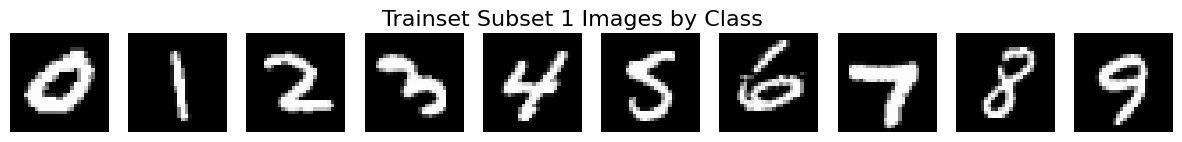

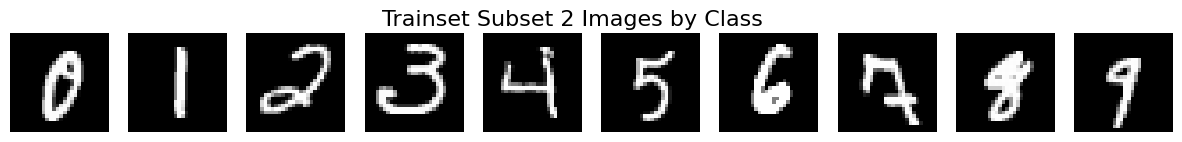

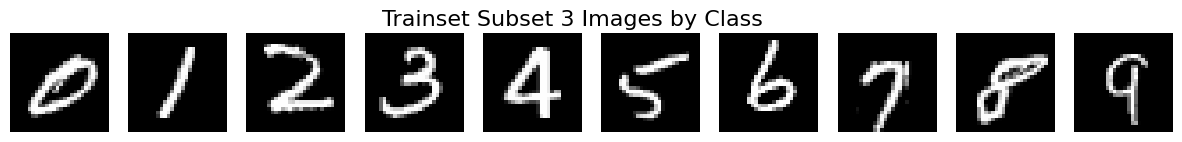

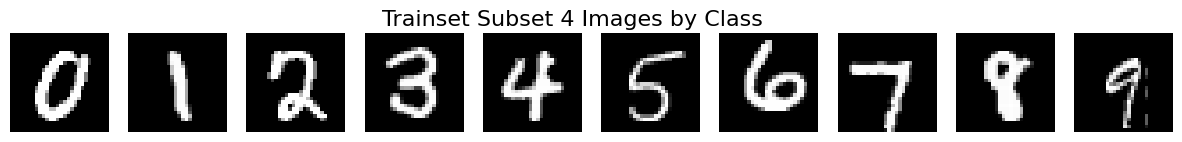

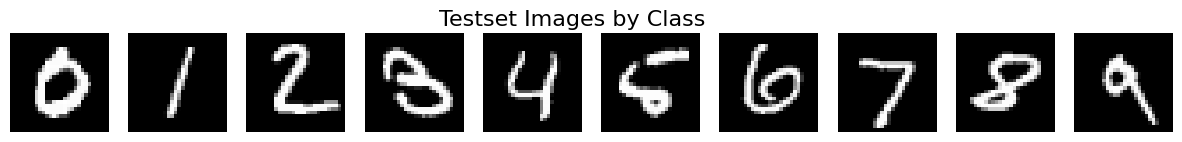

In [23]:
# Going through the dataloader to extract an image per class

train_images1 = get_images_by_class(train_loader1)
train_images2 = get_images_by_class(train_loader2)
train_images3 = get_images_by_class(train_loader3)
train_images4 = get_images_by_class(train_loader4)
train_images5 = get_images_by_class(train_loader5)
train_images6 = get_images_by_class(train_loader6)
train_images7 = get_images_by_class(train_loader7)
train_images8 = get_images_by_class(train_loader8)
train_images9 = get_images_by_class(train_loader9)
train_images10 = get_images_by_class(train_loader10)
train_images11 = get_images_by_class(train_loader11)
train_images12 = get_images_by_class(train_loader12)
train_images13 = get_images_by_class(train_loader13)
train_images14 = get_images_by_class(train_loader14)
train_images15 = get_images_by_class(train_loader15)
train_images16 = get_images_by_class(train_loader16)
train_images17 = get_images_by_class(train_loader17)
train_images18 = get_images_by_class(train_loader18)
train_images19 = get_images_by_class(train_loader19)
train_images20 = get_images_by_class(train_loader20)
train_images21 = get_images_by_class(train_loader21)
train_images22 = get_images_by_class(train_loader22)
train_images23 = get_images_by_class(train_loader23)
train_images24 = get_images_by_class(train_loader24)
train_images25 = get_images_by_class(train_loader25)
train_images26 = get_images_by_class(train_loader26)
train_images27 = get_images_by_class(train_loader27)
train_images28 = get_images_by_class(train_loader28)
train_images29 = get_images_by_class(train_loader29)
train_images30 = get_images_by_class(train_loader30)
train_images31 = get_images_by_class(train_loader31)
train_images32 = get_images_by_class(train_loader32)
train_images33 = get_images_by_class(train_loader33)
train_images34 = get_images_by_class(train_loader34)
train_images35 = get_images_by_class(train_loader35)
train_images36 = get_images_by_class(train_loader36)
train_images37 = get_images_by_class(train_loader37)
train_images38 = get_images_by_class(train_loader38)
train_images39 = get_images_by_class(train_loader39)
train_images40 = get_images_by_class(train_loader40)
train_images41 = get_images_by_class(train_loader41)
train_images42 = get_images_by_class(train_loader42)
train_images43 = get_images_by_class(train_loader43)
train_images44 = get_images_by_class(train_loader44)
train_images45 = get_images_by_class(train_loader45)
train_images46 = get_images_by_class(train_loader46)
train_images47 = get_images_by_class(train_loader47)
train_images48 = get_images_by_class(train_loader48)
train_images49 = get_images_by_class(train_loader49)
train_images50 = get_images_by_class(train_loader50)
train_images51 = get_images_by_class(train_loader51)
train_images52 = get_images_by_class(train_loader52)
train_images53 = get_images_by_class(train_loader53)
train_images54 = get_images_by_class(train_loader54)
train_images55 = get_images_by_class(train_loader55)
train_images56 = get_images_by_class(train_loader56)
train_images57 = get_images_by_class(train_loader57)
train_images58 = get_images_by_class(train_loader58)
train_images59 = get_images_by_class(train_loader59)
train_images60 = get_images_by_class(train_loader60)
train_images61 = get_images_by_class(train_loader61)
train_images62 = get_images_by_class(train_loader62)
train_images63 = get_images_by_class(train_loader63)
train_images64 = get_images_by_class(train_loader64)
train_images65 = get_images_by_class(train_loader65)
train_images66 = get_images_by_class(train_loader66)
train_images67 = get_images_by_class(train_loader67)
train_images68 = get_images_by_class(train_loader68)
train_images69 = get_images_by_class(train_loader69)
train_images70 = get_images_by_class(train_loader70)
train_images71 = get_images_by_class(train_loader71)
train_images72 = get_images_by_class(train_loader72)
train_images73 = get_images_by_class(train_loader73)
train_images74 = get_images_by_class(train_loader74)
train_images75 = get_images_by_class(train_loader75)
train_images76 = get_images_by_class(train_loader76)
train_images77 = get_images_by_class(train_loader77)
train_images78 = get_images_by_class(train_loader78)
train_images79 = get_images_by_class(train_loader79)
train_images80 = get_images_by_class(train_loader80)
test_images = get_images_by_class(test_loader)

plot_images(train_images1, "Trainset Subset 1 Images by Class")
plot_images(train_images2, "Trainset Subset 2 Images by Class")
plot_images(train_images3, "Trainset Subset 3 Images by Class")
plot_images(train_images4, "Trainset Subset 4 Images by Class")
plot_images(train_images5, "Trainset Subset 5 Images by Class")
plot_images(train_images6, "Trainset Subset 6 Images by Class")
plot_images(train_images7, "Trainset Subset 7 Images by Class")
plot_images(train_images8, "Trainset Subset 8 Images by Class")
plot_images(train_images9, "Trainset Subset 9 Images by Class")
plot_images(train_images10, "Trainset Subset 10 Images by Class")
plot_images(train_images11, "Trainset Subset 11 Images by Class")
plot_images(train_images12, "Trainset Subset 12 Images by Class")
plot_images(train_images13, "Trainset Subset 13 Images by Class")
plot_images(train_images14, "Trainset Subset 14 Images by Class")
plot_images(train_images15, "Trainset Subset 15 Images by Class")
plot_images(train_images16, "Trainset Subset 16 Images by Class")
plot_images(train_images17, "Trainset Subset 17 Images by Class")
plot_images(train_images18, "Trainset Subset 18 Images by Class")
plot_images(train_images19, "Trainset Subset 19 Images by Class")
plot_images(train_images20, "Trainset Subset 20 Images by Class")
plot_images(train_images21, "Trainset Subset 21 Images by Class")
plot_images(train_images22, "Trainset Subset 22 Images by Class")
plot_images(train_images23, "Trainset Subset 23 Images by Class")
plot_images(train_images24, "Trainset Subset 24 Images by Class")
plot_images(train_images25, "Trainset Subset 25 Images by Class")
plot_images(train_images26, "Trainset Subset 26 Images by Class")
plot_images(train_images27, "Trainset Subset 27 Images by Class")
plot_images(train_images28, "Trainset Subset 28 Images by Class")
plot_images(train_images29, "Trainset Subset 29 Images by Class")
plot_images(train_images30, "Trainset Subset 30 Images by Class")
plot_images(train_images31, "Trainset Subset 31 Images by Class")
plot_images(train_images32, "Trainset Subset 32 Images by Class")
plot_images(train_images33, "Trainset Subset 33 Images by Class")
plot_images(train_images34, "Trainset Subset 34 Images by Class")
plot_images(train_images35, "Trainset Subset 35 Images by Class")
plot_images(train_images36, "Trainset Subset 36 Images by Class")
plot_images(train_images37, "Trainset Subset 37 Images by Class")
plot_images(train_images38, "Trainset Subset 38 Images by Class")
plot_images(train_images39, "Trainset Subset 39 Images by Class")
plot_images(train_images40, "Trainset Subset 40 Images by Class")
plot_images(train_images41, "Trainset Subset 41 Images by Class")
plot_images(train_images42, "Trainset Subset 42 Images by Class")
plot_images(train_images43, "Trainset Subset 43 Images by Class")
plot_images(train_images44, "Trainset Subset 44 Images by Class")
plot_images(train_images45, "Trainset Subset 45 Images by Class")
plot_images(train_images46, "Trainset Subset 46 Images by Class")
plot_images(train_images47, "Trainset Subset 47 Images by Class")
plot_images(train_images48, "Trainset Subset 48 Images by Class")
plot_images(train_images49, "Trainset Subset 49 Images by Class")
plot_images(train_images50, "Trainset Subset 50 Images by Class")
plot_images(train_images51, "Trainset Subset 51 Images by Class")
plot_images(train_images52, "Trainset Subset 52 Images by Class")
plot_images(train_images53, "Trainset Subset 53 Images by Class")
plot_images(train_images54, "Trainset Subset 54 Images by Class")
plot_images(train_images55, "Trainset Subset 55 Images by Class")
plot_images(train_images56, "Trainset Subset 56 Images by Class")
plot_images(train_images57, "Trainset Subset 57 Images by Class")
plot_images(train_images58, "Trainset Subset 58 Images by Class")
plot_images(train_images59, "Trainset Subset 59 Images by Class")
plot_images(train_images60, "Trainset Subset 60 Images by Class")
plot_images(train_images61, "Trainset Subset 61 Images by Class")
plot_images(train_images62, "Trainset Subset 62 Images by Class")
plot_images(train_images63, "Trainset Subset 63 Images by Class")
plot_images(train_images64, "Trainset Subset 64 Images by Class")
plot_images(train_images65, "Trainset Subset 65 Images by Class")
plot_images(train_images66, "Trainset Subset 66 Images by Class")
plot_images(train_images67, "Trainset Subset 67 Images by Class")
plot_images(train_images68, "Trainset Subset 68 Images by Class")
plot_images(train_images69, "Trainset Subset 69 Images by Class")
plot_images(train_images70, "Trainset Subset 70 Images by Class")
plot_images(train_images71, "Trainset Subset 71 Images by Class")
plot_images(train_images72, "Trainset Subset 72 Images by Class")
plot_images(train_images73, "Trainset Subset 73 Images by Class")
plot_images(train_images74, "Trainset Subset 74 Images by Class")
plot_images(train_images75, "Trainset Subset 75 Images by Class")
plot_images(train_images76, "Trainset Subset 76 Images by Class")
plot_images(train_images77, "Trainset Subset 77 Images by Class")
plot_images(train_images78, "Trainset Subset 78 Images by Class")
plot_images(train_images79, "Trainset Subset 79 Images by Class")
plot_images(train_images80, "Trainset Subset 80 Images by Class")
plot_images(test_images, "Testset Images by Class")

#### **Verify that the 10 first images are visually different**

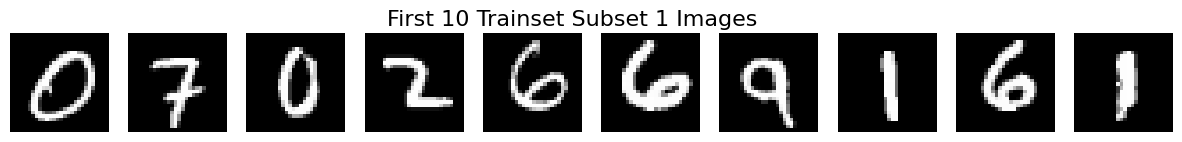

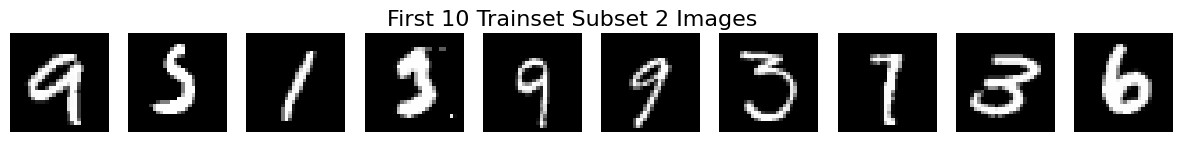

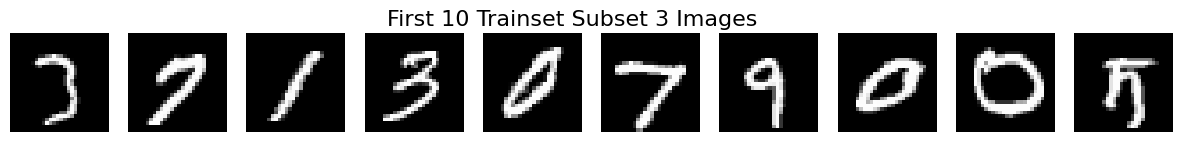

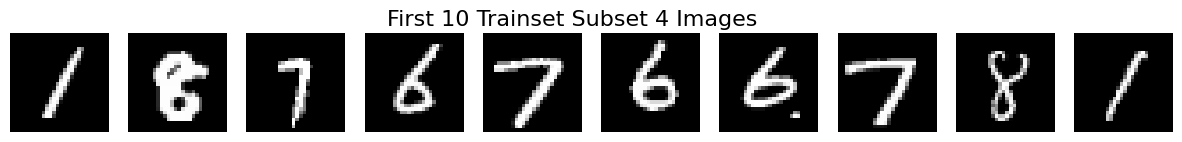

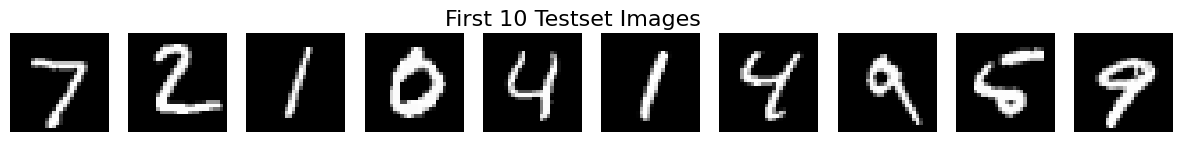

In [24]:
plot_first_images(train_loader1, "First 10 Trainset Subset 1 Images")
plot_first_images(train_loader2, "First 10 Trainset Subset 2 Images")
plot_first_images(train_loader3, "First 10 Trainset Subset 3 Images")
plot_first_images(train_loader4, "First 10 Trainset Subset 4 Images")
plot_first_images(train_loader5, "First 10 Trainset Subset 5 Images")
plot_first_images(train_loader6, "First 10 Trainset Subset 6 Images")
plot_first_images(train_loader7, "First 10 Trainset Subset 7 Images")
plot_first_images(train_loader8, "First 10 Trainset Subset 8 Images")
plot_first_images(train_loader9, "First 10 Trainset Subset 9 Images")
plot_first_images(train_loader10, "First 10 Trainset Subset 10 Images")
plot_first_images(train_loader11, "First 10 Trainset Subset 11 Images")
plot_first_images(train_loader12, "First 10 Trainset Subset 12 Images")
plot_first_images(train_loader13, "First 10 Trainset Subset 13 Images")
plot_first_images(train_loader14, "First 10 Trainset Subset 14 Images")
plot_first_images(train_loader15, "First 10 Trainset Subset 15 Images")
plot_first_images(train_loader16, "First 10 Trainset Subset 16 Images")
plot_first_images(train_loader17, "First 10 Trainset Subset 17 Images")
plot_first_images(train_loader18, "First 10 Trainset Subset 18 Images")
plot_first_images(train_loader19, "First 10 Trainset Subset 19 Images")
plot_first_images(train_loader20, "First 10 Trainset Subset 20 Images")
plot_first_images(train_loader21, "First 10 Trainset Subset 21 Images")
plot_first_images(train_loader22, "First 10 Trainset Subset 22 Images")
plot_first_images(train_loader23, "First 10 Trainset Subset 23 Images")
plot_first_images(train_loader24, "First 10 Trainset Subset 24 Images")
plot_first_images(train_loader25, "First 10 Trainset Subset 25 Images")
plot_first_images(train_loader26, "First 10 Trainset Subset 26 Images")
plot_first_images(train_loader27, "First 10 Trainset Subset 27 Images")
plot_first_images(train_loader28, "First 10 Trainset Subset 28 Images")
plot_first_images(train_loader29, "First 10 Trainset Subset 29 Images")
plot_first_images(train_loader30, "First 10 Trainset Subset 30 Images")
plot_first_images(train_loader31, "First 10 Trainset Subset 31 Images")
plot_first_images(train_loader32, "First 10 Trainset Subset 32 Images")
plot_first_images(train_loader33, "First 10 Trainset Subset 33 Images")
plot_first_images(train_loader34, "First 10 Trainset Subset 34 Images")
plot_first_images(train_loader35, "First 10 Trainset Subset 35 Images")
plot_first_images(train_loader36, "First 10 Trainset Subset 36 Images")
plot_first_images(train_loader37, "First 10 Trainset Subset 37 Images")
plot_first_images(train_loader38, "First 10 Trainset Subset 38 Images")
plot_first_images(train_loader39, "First 10 Trainset Subset 39 Images")
plot_first_images(train_loader40, "First 10 Trainset Subset 40 Images")
plot_first_images(train_loader41, "First 10 Trainset Subset 41 Images")
plot_first_images(train_loader42, "First 10 Trainset Subset 42 Images")
plot_first_images(train_loader43, "First 10 Trainset Subset 43 Images")
plot_first_images(train_loader44, "First 10 Trainset Subset 44 Images")
plot_first_images(train_loader45, "First 10 Trainset Subset 45 Images")
plot_first_images(train_loader46, "First 10 Trainset Subset 46 Images")
plot_first_images(train_loader47, "First 10 Trainset Subset 47 Images")
plot_first_images(train_loader48, "First 10 Trainset Subset 48 Images")
plot_first_images(train_loader49, "First 10 Trainset Subset 49 Images")
plot_first_images(train_loader50, "First 10 Trainset Subset 50 Images")
plot_first_images(train_loader51, "First 10 Trainset Subset 51 Images")
plot_first_images(train_loader52, "First 10 Trainset Subset 52 Images")
plot_first_images(train_loader53, "First 10 Trainset Subset 53 Images")
plot_first_images(train_loader54, "First 10 Trainset Subset 54 Images")
plot_first_images(train_loader55, "First 10 Trainset Subset 55 Images")
plot_first_images(train_loader56, "First 10 Trainset Subset 56 Images")
plot_first_images(train_loader57, "First 10 Trainset Subset 57 Images")
plot_first_images(train_loader58, "First 10 Trainset Subset 58 Images")
plot_first_images(train_loader59, "First 10 Trainset Subset 59 Images")
plot_first_images(train_loader60, "First 10 Trainset Subset 60 Images")
plot_first_images(train_loader61, "First 10 Trainset Subset 61 Images")
plot_first_images(train_loader62, "First 10 Trainset Subset 62 Images")
plot_first_images(train_loader63, "First 10 Trainset Subset 63 Images")
plot_first_images(train_loader64, "First 10 Trainset Subset 64 Images")
plot_first_images(train_loader65, "First 10 Trainset Subset 65 Images")
plot_first_images(train_loader66, "First 10 Trainset Subset 66 Images")
plot_first_images(train_loader67, "First 10 Trainset Subset 67 Images")
plot_first_images(train_loader68, "First 10 Trainset Subset 68 Images")
plot_first_images(train_loader69, "First 10 Trainset Subset 69 Images")
plot_first_images(train_loader70, "First 10 Trainset Subset 70 Images")
plot_first_images(train_loader71, "First 10 Trainset Subset 71 Images")
plot_first_images(train_loader72, "First 10 Trainset Subset 72 Images")
plot_first_images(train_loader73, "First 10 Trainset Subset 73 Images")
plot_first_images(train_loader74, "First 10 Trainset Subset 74 Images")
plot_first_images(train_loader75, "First 10 Trainset Subset 75 Images")
plot_first_images(train_loader76, "First 10 Trainset Subset 76 Images")
plot_first_images(train_loader77, "First 10 Trainset Subset 77 Images")
plot_first_images(train_loader78, "First 10 Trainset Subset 78 Images")
plot_first_images(train_loader79, "First 10 Trainset Subset 79 Images")
plot_first_images(train_loader80, "First 10 Trainset Subset 80 Images")
plot_first_images(test_loader, "First 10 Testset Images")

### **Defining some variables and creating files & folders**

In [8]:
HDFP = "./volumes/Ultra Touch" # Load HHD

SAVE_LOC = HDFP + "/lobranch-snapshot/diffbitwidth-adaptive-rank/lenet/lobranch"
if not os.path.exists(SAVE_LOC):
    os.makedirs(SAVE_LOC)

SAVE_LOC_OLC = HDFP + "/lobranch-snapshot/diffbitwidth-adaptive-rank/lenet/old-lc"
if not os.path.exists(SAVE_LOC_OLC):
    os.makedirs(SAVE_LOC_OLC)

SAVE_BRANCH_PRETRAINING = HDFP + "/lobranch-snapshot/branchpoints/lenet/pretraining"
if not os.path.exists(SAVE_BRANCH_PRETRAINING):
    os.makedirs(SAVE_BRANCH_PRETRAINING)

SAVE_BRANCH = HDFP + "/lobranch-snapshot/branchpoints/lenet/branch"
if not os.path.exists(SAVE_BRANCH):
    os.makedirs(SAVE_BRANCH)

### **Pretraining the model**

In [14]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_for_checkpoint = LeNet()

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model_for_checkpoint = nn.DataParallel(model_for_checkpoint)
    model_for_checkpoint.to(device)
else:
    print("Let's use", torch.cuda.device_count(), "GPU!")
    model_for_checkpoint.to(device)

# Training code
NUM_EPOCHES = 50
learning_rate = 0.005
isLoop = True
optimizer = torch.optim.SGD(model_for_checkpoint.parameters(), lr=learning_rate)

# Initialize a new W&B run
wandb.init(project="LeNet", 
           name="LeNet-Pretraining-Without-Incremental-Learning", 
           tags=["LeNet", "Pretraining", "Without-Incremental-Learning", "MNIST"],
           config={"num_epoches": NUM_EPOCHES,
                    "model": "LeNet",
                    "train dataset": "MNIST train dataset[:]",
                    "test dataset": "MNIST test dataset[:]",
                    "batch_size on training": train_batch_size,
                    "batch_size on testing": test_batch_size,
                    "num_workers": num_work,
                    "learning_rate": learning_rate,
                    "optimizer": "SGD",
                }
           )

print("Start of model training...")
for epoch in range(NUM_EPOCHES):
    if not isLoop:
        break
    else:
        train_loss = 0.0
        valid_loss = 0.0

        train_correct = 0
        train_total = 0

        valid_correct = 0
        valid_total = 0
        
        model_for_checkpoint.train()
        for iter, data in enumerate(train_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            output = model_for_checkpoint(inputs)

            loss = torch.nn.CrossEntropyLoss()(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(output, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

            train_acc = torch.eq(output.argmax(-1), labels).float().mean()

        model_for_checkpoint.eval()
        with torch.no_grad():  # Gradient computation is not needed for validation
            for data, target in test_loader:
                # Move data and target to the correct device
                data, target = data.to(device), target.to(device)

                output = model_for_checkpoint(data)
                loss = torch.nn.CrossEntropyLoss()(output, target)
                valid_loss += loss.item() * data.size(0)

                _, predicted = torch.max(output, 1)
                valid_correct += (predicted == target).sum().item()
                valid_total += target.size(0)

                valid_acc = torch.eq(output.argmax(-1), target).float().mean()


    # Calculate average losses
    train_loss /= len(train_loader.dataset)
    valid_loss /= len(test_loader.dataset)

    train_accuarcy = train_correct / train_total
    valid_accuracy = valid_correct / valid_total

    if valid_accuracy > 0.70:
        torch.save(model_for_checkpoint.state_dict(), SAVE_BRANCH_PRETRAINING + "/branch_{:.3f}.pt".format(valid_accuracy))
        print("Model saved with accuracy: {:.3f} in the file: branch_{:.3f}.pt".format(valid_accuracy, valid_accuracy))
        # Comment the line below if you want to train on the whole dataset
        isLoop = False

    print("Epoch: [{}/{}], Training Loss: {:.6f}, Validation Loss: {:.6f}, Training Accuracy: {:.6f}, Validation Accuracy: {:.6f}".format(epoch, NUM_EPOCHES-1, train_loss, valid_loss, train_accuarcy, valid_accuracy))

    wandb.log({
        "train_loss": train_loss,
        "valid_loss": valid_loss,
        "train_accuracy": train_accuarcy,
        "valid_accuracy": valid_accuracy
    })


print("End of model training...")

# Finish the wandb run
wandb.finish()

Let's use 1 GPU!


Start of model training...
Epoch: [0/49], Training Loss: 1.891492, Validation Loss: 1.149016, Training Accuracy: 0.558367, Validation Accuracy: 0.745900
End of model training...


train_accuracy,▁
train_loss,▁
valid_accuracy,▁
valid_loss,▁
train_accuracy,0.55837
train_loss,1.89149
valid_accuracy,0.7459
valid_loss,1.14902


---

## **First version : LeNet without Incremental Learning**

In [ ]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_for_checkpoint = LeNet()

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model_for_checkpoint = nn.DataParallel(model_for_checkpoint)
    model_for_checkpoint.to(device)
else:
    print("Let's use", torch.cuda.device_count(), "GPU!")
    model_for_checkpoint.to(device)

# Training code
NUM_EPOCHES = 50
learning_rate = 0.02
isLoop = True
optimizer = torch.optim.SGD(model_for_checkpoint.parameters(), lr=learning_rate)

# Initialize a new W&B run
wandb.init(project="LeNet", 
           name="LeNet-Without-Incremental-Learning", 
           tags=["LeNet", "Without-Incremental-Learning", "MNIST"],
           config={"num_epoches": NUM_EPOCHES,
                    "model": "LeNet",
                    "train dataset": "MNIST train dataset[:]",
                    "test dataset": "MNIST test dataset[:]",
                    "batch_size on training": train_batch_size,
                    "batch_size on testing": test_batch_size,
                    "num_workers": num_work,
                    "learning_rate": learning_rate,
                    "optimizer": "SGD",
                }
           )

print("Start of model training...")
for epoch in range(NUM_EPOCHES):
    if not isLoop:
        break
    else:
        train_loss = 0.0
        valid_loss = 0.0

        train_correct = 0
        train_total = 0

        valid_correct = 0
        valid_total = 0
        
        model_for_checkpoint.train()
        for iter, data in enumerate(train_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            output = model_for_checkpoint(inputs)

            loss = torch.nn.CrossEntropyLoss()(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(output, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

            train_acc = torch.eq(output.argmax(-1), labels).float().mean()

        model_for_checkpoint.eval()
        with torch.no_grad():  # Gradient computation is not needed for validation
            for data, target in test_loader:
                # Move data and target to the correct device
                data, target = data.to(device), target.to(device)

                output = model_for_checkpoint(data)
                loss = torch.nn.CrossEntropyLoss()(output, target)
                valid_loss += loss.item() * data.size(0)

                _, predicted = torch.max(output, 1)
                valid_correct += (predicted == target).sum().item()
                valid_total += target.size(0)

                valid_acc = torch.eq(output.argmax(-1), target).float().mean()


    # Calculate average losses
    train_loss /= len(train_loader.dataset)
    valid_loss /= len(test_loader.dataset)

    train_accuarcy = train_correct / train_total
    valid_accuracy = valid_correct / valid_total

    print("Epoch: [{}/{}], Training Loss: {:.6f}, Validation Loss: {:.6f}, Training Accuracy: {:.6f}, Validation Accuracy: {:.6f}".format(epoch, NUM_EPOCHES-1, train_loss, valid_loss, train_accuarcy, valid_accuracy))

    wandb.log({
        "train_loss": train_loss,
        "valid_loss": valid_loss,
        "train_accuracy": train_accuarcy,
        "valid_accuracy": valid_accuracy
    })


print("End of model training...")

# Finish the wandb run
wandb.finish()

---

## **Second version : LeNet with Incremental Learning**

##### **Training on trainloader1**

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_with_incremental_learning = LeNet()

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model_with_incremental_learning = nn.DataParallel(model_with_incremental_learning)
    model_with_incremental_learning.to(device)
else:
    print("Let's use", torch.cuda.device_count(), "GPU!")
    model_with_incremental_learning.to(device)

# Training code
NUM_EPOCHES = 45
learning_rate = 0.01
isLoop = True
optimizer = torch.optim.SGD(model_with_incremental_learning.parameters(), lr=learning_rate)

# Initialize a new W&B run
wandb.init(project="LeNet", 
           name="LeNet-With-Incremental-Learning", 
           tags=["LeNet", "With-Incremental-Learning", "MNIST"],
           config={"num_epoches": NUM_EPOCHES,
                    "model": "LeNet",
                    "train dataset": "CIFAR10 train dataloader1",
                    "test dataset": "CIFAR10 test dataset[:]",
                    "batch_size on training": train_batch_size,
                    "batch_size on testing": test_batch_size,
                    "num_workers": num_work,
                    "learning_rate": learning_rate,
                    "optimizer": "SGD",
                }
           )



print("Start of model training on dataloader1...")
for epoch in range(NUM_EPOCHES):
    if not isLoop:
        break
    else:
        train_loss = 0.0
        valid_loss = 0.0

        train_correct = 0
        train_total = 0

        valid_correct = 0
        valid_total = 0
        
        model_with_incremental_learning.train()
        for iter, data in enumerate(train_loader1):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            output = model_with_incremental_learning(inputs)

            loss = torch.nn.CrossEntropyLoss()(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(output, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

            train_acc = torch.eq(output.argmax(-1), labels).float().mean()

        model_with_incremental_learning.eval()
        with torch.no_grad():  # Gradient computation is not needed for validation
            for data, target in test_loader:
                # Move data and target to the correct device
                data, target = data.to(device), target.to(device)

                output = model_with_incremental_learning(data)
                loss = torch.nn.CrossEntropyLoss()(output, target)
                valid_loss += loss.item() * data.size(0)

                _, predicted = torch.max(output, 1)
                valid_correct += (predicted == target).sum().item()
                valid_total += target.size(0)

                valid_acc = torch.eq(output.argmax(-1), target).float().mean()


    # Calculate average losses
    train_loss /= len(train_loader1.dataset)
    valid_loss /= len(test_loader.dataset)

    train_accuarcy = train_correct / train_total
    valid_accuracy = valid_correct / valid_total

    print("Epoch: [{}/{}], Training Loss: {:.6f}, Validation Loss: {:.6f}, Training Accuracy: {:.6f}, Validation Accuracy: {:.6f}".format(epoch, NUM_EPOCHES-1, train_loss, valid_loss, train_accuarcy, valid_accuracy))

    wandb.log({
        "train_loss": train_loss,
        "valid_loss": valid_loss,
        "train_accuracy": train_accuarcy,
        "valid_accuracy": valid_accuracy,
        "epoch": epoch
    })


print("End of model training on dataloader1...")

##### **Training on trainloader2**

In [ ]:

print("-----------------------------------")

# Training code on dataloader2
print("Start of model training on dataloader2...")

for epoch in range(NUM_EPOCHES):
    if not isLoop:
        break
    else:
        train_loss = 0.0
        valid_loss = 0.0

        train_correct = 0
        train_total = 0

        valid_correct = 0
        valid_total = 0
        
        model_with_incremental_learning.train()
        for iter, data in enumerate(train_loader2):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            output = model_with_incremental_learning(inputs)

            loss = torch.nn.CrossEntropyLoss()(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(output, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

            train_acc = torch.eq(output.argmax(-1), labels).float().mean()

        model_with_incremental_learning.eval()
        with torch.no_grad():  # Gradient computation is not needed for validation
            for data, target in test_loader:
                # Move data and target to the correct device
                data, target = data.to(device), target.to(device)

                output = model_with_incremental_learning(data)
                loss = torch.nn.CrossEntropyLoss()(output, target)
                valid_loss += loss.item() * data.size(0)

                _, predicted = torch.max(output, 1)
                valid_correct += (predicted == target).sum().item()
                valid_total += target.size(0)

                valid_acc = torch.eq(output.argmax(-1), target).float().mean()


    # Calculate average losses
    train_loss /= len(train_loader2.dataset)
    valid_loss /= len(test_loader.dataset)

    train_accuarcy = train_correct / train_total
    valid_accuracy = valid_correct / valid_total

    print("Epoch: [{}/{}], Training Loss: {:.6f}, Validation Loss: {:.6f}, Training Accuracy: {:.6f}, Validation Accuracy: {:.6f}".format(epoch, NUM_EPOCHES-1, train_loss, valid_loss, train_accuarcy, valid_accuracy))

    wandb.log({
        "train_loss": train_loss,
        "valid_loss": valid_loss,
        "train_accuracy": train_accuarcy,
        "valid_accuracy": valid_accuracy,
        "epoch": epoch
    })


print("End of model training on dataloader2...")

##### **Training on trainloader3**

In [ ]:

print("-----------------------------------")

# Training code on dataloader2
print("Start of model training on dataloader3...")

for epoch in range(NUM_EPOCHES):
    if not isLoop:
        break
    else:
        train_loss = 0.0
        valid_loss = 0.0

        train_correct = 0
        train_total = 0

        valid_correct = 0
        valid_total = 0
        
        model_with_incremental_learning.train()
        for iter, data in enumerate(train_loader3):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            output = model_with_incremental_learning(inputs)

            loss = torch.nn.CrossEntropyLoss()(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(output, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

            train_acc = torch.eq(output.argmax(-1), labels).float().mean()

        model_with_incremental_learning.eval()
        with torch.no_grad():  # Gradient computation is not needed for validation
            for data, target in test_loader:
                # Move data and target to the correct device
                data, target = data.to(device), target.to(device)

                output = model_with_incremental_learning(data)
                loss = torch.nn.CrossEntropyLoss()(output, target)
                valid_loss += loss.item() * data.size(0)

                _, predicted = torch.max(output, 1)
                valid_correct += (predicted == target).sum().item()
                valid_total += target.size(0)

                valid_acc = torch.eq(output.argmax(-1), target).float().mean()


    # Calculate average losses
    train_loss /= len(train_loader3.dataset)
    valid_loss /= len(test_loader.dataset)

    train_accuarcy = train_correct / train_total
    valid_accuracy = valid_correct / valid_total

    print("Epoch: [{}/{}], Training Loss: {:.6f}, Validation Loss: {:.6f}, Training Accuracy: {:.6f}, Validation Accuracy: {:.6f}".format(epoch, NUM_EPOCHES-1, train_loss, valid_loss, train_accuarcy, valid_accuracy))

    wandb.log({
        "train_loss": train_loss,
        "valid_loss": valid_loss,
        "train_accuracy": train_accuarcy,
        "valid_accuracy": valid_accuracy,
        "epoch": epoch
    })


print("End of model training on dataloader3...")
# Finish the wandb run
wandb.finish()

---

## **Third version : LeNet with Incremental Learning, LC-checkpoint, and Delta-LoRA**

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_with_incremental_learning_lc_dlora = LeNet()

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model_with_incremental_learning_lc_dlora = nn.DataParallel(model_with_incremental_learning_lc_dlora)
    model_with_incremental_learning_lc_dlora.to(device)
else:
    print("Let's use", torch.cuda.device_count(), "GPU!")
    model_with_incremental_learning_lc_dlora.to(device)

# Training code
NUM_EPOCHES = 30
learning_rate = 0.1
learning_rate_dloralc = 0.1
learning_rate1 = 0.005
# super_step = len(train_loader2)
# super_step = 20
isLoop = True

optimizer = torch.optim.SGD(model_with_incremental_learning_lc_dlora.parameters(), lr=learning_rate1)

# Initialize a new W&B run
wandb.init(project="LeNet", 
           name="LeNet-With-Incremental-Learning_LC_DLORA-Without-Restore_25_25_25_25", 
           tags=["LeNet", "With-Incremental-Learning_LC_DLORA", "MNIST"],
           config={"num_epoches": NUM_EPOCHES,
                    "model": "LeNet",
                    "splitting": "25-25-25-25",
                    "train dataset 1": "MNIST train dataloader1",
                    "test dataset": "MNIST test dataset[:]",
                    "batch_size on training": train_batch_size,
                    "batch_size on testing": test_batch_size,
                    "num_workers": num_work,
                    "learning_rate_nothing": learning_rate,
                    "learning_rate_dloralc": learning_rate_dloralc,
                    "optimizer": "SGD"
                }
           )

print("Start of model training on dataloader1...")
for epoch in range(NUM_EPOCHES):
    if not isLoop:
        break
    else:
        train_loss = 0.0
        valid_loss = 0.0

        train_correct = 0
        train_total = 0

        valid_correct = 0
        valid_total = 0
        
        model_with_incremental_learning_lc_dlora.train()
        for iter, data in enumerate(train_loader1):

            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            output = model_with_incremental_learning_lc_dlora(inputs)

            loss = torch.nn.CrossEntropyLoss()(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss * inputs.size(0)

            _, predicted = torch.max(output, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

            train_acc = torch.eq(output.argmax(-1), labels).float().mean()

        model_with_incremental_learning_lc_dlora.eval()
        with torch.no_grad():  # Gradient computation is not needed for validation
            for data, target in test_loader:
                # Move data and target to the correct device
                data, target = data.to(device), target.to(device)

                output = model_with_incremental_learning_lc_dlora(data)
                loss = torch.nn.CrossEntropyLoss()(output, target)
                valid_loss += loss.item() * data.size(0)

                _, predicted = torch.max(output, 1)
                valid_correct += (predicted == target).sum().item()
                valid_total += target.size(0)

                valid_acc = torch.eq(output.argmax(-1), target).float().mean()

    # Calculate average losses
    train_loss /= len(train_loader1.dataset)
    valid_loss /= len(test_loader.dataset)

    train_accuarcy = train_correct / train_total
    valid_accuracy = valid_correct / valid_total

    if valid_accuracy > 0.7:
        rounded_valid_acc = round(valid_accuracy, 4)
        # torch.save(model_for_checkpoint.state_dict(), HDFP + "/lobranch-snapshot/branchpoints/vit/branch_{}.pt".format(rounded_valid_acc))
        torch.save(model_with_incremental_learning_lc_dlora.state_dict(), HDFP + "/lobranch-snapshot/branchpoints/lenet/branch_{}.pt".format(rounded_valid_acc))
        print("Model saved at accuracy: {:.4f}".format(rounded_valid_acc))
        isLoop = False
        break
    # if valid_accuracy > 0.90:
    #     isLoop = False
    #     break

    print("Epoch: [{}/{}], Training Loss: {:.6f}, Validation Loss: {:.6f}, Training Accuracy: {:.6f}, Validation Accuracy: {:.6f}".format(epoch, NUM_EPOCHES-1, train_loss, valid_loss, train_accuarcy, valid_accuracy))

    wandb.log({
        "train_loss_dloralc": train_loss,
        "valid_loss_dloralc": valid_loss,
        "train_accuracy_dloralc": train_accuarcy,
        "valid_accuracy_dloralc": valid_accuracy,
        "train_loss_lc": train_loss,
        "valid_loss_lc": valid_loss,
        "train_accuracy_lc": train_accuarcy,
        "valid_accuracy_lc": valid_accuracy, 
        "train_loss": train_loss,
        "valid_loss": valid_loss,
        "train_accuracy": train_accuarcy,
        "valid_accuracy": valid_accuracy,
        "epoch": epoch,
    })
    # wandb.log({
    #     "train_loss_dloralc": train_loss,
    #     "valid_loss_dloralc": valid_loss,
    #     "train_accuracy_dloralc": train_accuarcy,
    #     "valid_accuracy_dloralc": valid_accuracy,
    #     "train_loss_lc": train_loss,
    #     "valid_loss_lc": valid_loss,
    #     "train_accuracy_lc": train_accuarcy,
    #     "valid_accuracy_lc": valid_accuracy, 
    #     "train_loss": train_loss,
    #     "valid_loss": valid_loss,
    #     "train_accuracy": train_accuarcy,
    #     "valid_accuracy": valid_accuracy,
    #     "valid_loss_dloralc_restored": valid_loss,
    #     "valid_accuracy_dloralc_restored": valid_accuracy,
    #     "epoch": epoch,
    # })

print("End of model training on dataloader1...")

Let's use 1 GPU!


Start of model training on dataloader1...
Epoch: [0/29], Training Loss: 2.263898, Validation Loss: 2.211693, Training Accuracy: 0.247016, Validation Accuracy: 0.452200
Epoch: [1/29], Training Loss: 2.111947, Validation Loss: 1.965460, Training Accuracy: 0.541380, Validation Accuracy: 0.571200
Epoch: [2/29], Training Loss: 1.775779, Validation Loss: 1.560456, Training Accuracy: 0.561387, Validation Accuracy: 0.603400
Model saved at accuracy: 0.7024
End of model training on dataloader1...


### **Working on training with delta-LoRA and LC-checkpoint** 

In [9]:
DECOMPOSED_LAYERS = ["classifier.1.weight", "classifier.3.weight"]
RANK = -1
SCALING = -1
BRANCH_ACC = "0.746"
learning_rate = 0.02
learning_rate_dloralc = 0.4
NUM_EPOCHES = 2

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
original = LeNet().to(device)
model_original = LeNet().to(device)
model_no_touch = LeNet().to(device)

In [11]:
BRANCH_LOC = HDFP + "/lobranch-snapshot/branchpoints/lenet/pretraining/branch_{}.pt".format(BRANCH_ACC)
original.load_state_dict(torch.load(BRANCH_LOC))
model_original.load_state_dict(torch.load(BRANCH_LOC))
model_no_touch.load_state_dict(torch.load(BRANCH_LOC))

<All keys matched successfully>

In [12]:
w, b = getBase(original)
model = LeNet_LowRank(w, b, rank = RANK).to(device)

In [13]:
print(model.state_dict().keys())

odict_keys(['feature.0.weight', 'feature.0.bias', 'feature.3.weight', 'feature.3.bias', 'classifier.1.alpha', 'classifier.1.beta', 'classifier.1.bias', 'classifier.3.alpha', 'classifier.3.beta', 'classifier.3.bias', 'classifier.5.weight', 'classifier.5.bias'])


In [14]:
load_sd_decomp(torch.load(BRANCH_LOC, map_location=device), model, DECOMPOSED_LAYERS)

In [15]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate_dloralc)
optimizer_lc_only = torch.optim.SGD(model_original.parameters(), lr=learning_rate)
optimizer_no_touch = torch.optim.SGD(model_no_touch.parameters(), lr=learning_rate)

In [16]:
full_accuracy = []
decomposed_full_accuracy = []
restored_accuracy = []
lc_accuracy = []

# Initialize the current iteration and set to 0
current_iter = 0
current_set = 0

# Initialize the current iteration and set to 0 for the old LC method
current_iter_old_lc = 0
current_set_old_lc = 0

acc = lambda x, y : (torch.max(x, 1)[1] == y).sum().item() / y.size(0)

In [17]:
# Initialize a new W&B run
wandb.init(project="LeNet", 
           name="LeNet-With-Incremental-Learning", 
           tags=["LeNet", "With-Incremental-Learning", "MNIST"],
           config={"num_epoches": NUM_EPOCHES,
                    "model": "LeNet",
                    "train dataset": "MNIST train dataset[:]",
                    "test dataset": "MNIST test dataset[:]",
                    "splitting": "80x1_25",
                    "batch_size on training": train_batch_size,
                    "batch_size on testing": test_batch_size,
                    "num_workers": num_work,
                    "learning_rate": learning_rate,
                    "learning_rate_dloralc": learning_rate_dloralc,
                    "optimizer": "SGD",
                }
           )

train_loader_list = [train_loader1, train_loader2, train_loader3, train_loader4, train_loader5, train_loader6, train_loader7, train_loader8, train_loader9, train_loader10, train_loader11, train_loader12, train_loader13, train_loader14, train_loader15, train_loader16, train_loader17, train_loader18, train_loader19, train_loader20,
                    train_loader21, train_loader22, train_loader23, train_loader24, train_loader25, train_loader26, train_loader27, train_loader28, train_loader29, train_loader30, train_loader31, train_loader32, train_loader33, train_loader34, train_loader35, train_loader36, train_loader37, train_loader38, train_loader39, train_loader40,
                    train_loader41, train_loader42, train_loader43, train_loader44, train_loader45, train_loader46, train_loader47, train_loader48, train_loader49, train_loader50, train_loader51, train_loader52, train_loader53, train_loader54, train_loader55, train_loader56, train_loader57, train_loader58, train_loader59, train_loader60,
                    train_loader61, train_loader62, train_loader63, train_loader64, train_loader65, train_loader66, train_loader67, train_loader68, train_loader69, train_loader70, train_loader71, train_loader72, train_loader73, train_loader74, train_loader75, train_loader76, train_loader77, train_loader78, train_loader79, train_loader80]

for j in range(len(train_loader_list)):
    train_loader_txt = "train_loader{}".format(j+1)
    print("--------------------------")
    print("Beginning of model training on {}...".format(train_loader_txt))

    full_accuracy_dloralc = 0
    decomposed_full_accuracy_dloralc = 0
    restored_accuracy_dloralc = 0
    lc_accuracy_dloralc = 0

    for epch in range(NUM_EPOCHES):
        for i, data in enumerate(train_loader_list[j], 0):

            SAVE_LOC_j = SAVE_LOC + "/"+train_loader_txt
            if not os.path.exists(SAVE_LOC_j):
                os.makedirs(SAVE_LOC_j)
                
            SAVE_LOC_OLC_j = SAVE_LOC_OLC + "/"+train_loader_txt
            if not os.path.exists(SAVE_LOC_OLC_j):
                os.makedirs(SAVE_LOC_OLC_j)
            print("Epoch: {}, Iteration: {}".format(epch, i))
            
            set_path = "/set_{}".format(current_set)
            if not os.path.exists(SAVE_LOC_j + set_path):
                os.makedirs(SAVE_LOC_j + set_path)

            if i == 0 and epch == 0: # first iteration, create baseline model
                base, base_decomp = lc.extract_weights_gpu(model, SAVE_LOC_j + 
                                                        "/set_{}".format(current_set), DECOMPOSED_LAYERS)
            else:
                if i % 10 == 0: 
                    # full snapshot!
                    new_model = lazy_restore_gpu(base, base_decomp, bias, LeNet(), 
                                            original.state_dict(), DECOMPOSED_LAYERS, rank = RANK, scaling = SCALING)
                    original = new_model # Changing previous "original model" used to restore the loRA model.
                    
                    current_set += 1
                    current_iter = 0

                    set_path = "/set_{}".format(current_set)
                    if not os.path.exists(SAVE_LOC_j + set_path):
                        os.makedirs(SAVE_LOC_j + set_path)
                    
                    # Rebuilding LoRA layers => reset model!
                    w, b = getBase(original)
                    model = LeNet_LowRank(w, b, rank = RANK).to(device)
                    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
                    load_sd_decomp(original.state_dict(), model, DECOMPOSED_LAYERS)
                    base, base_decomp = lc.extract_weights_gpu(model, SAVE_LOC_j + 
                                                        "/set_{}".format(current_set), DECOMPOSED_LAYERS)

                else:
                    # Delta-compression
                    delta, decomp_delta, bias = lc.generate_delta_gpu(base, 
                                                                    base_decomp, model.state_dict(), DECOMPOSED_LAYERS)
                    compressed_delta, full_delta, compressed_dcomp_delta, full_dcomp_delta  = lc.compress_delta(delta, 
                                                                                                                decomp_delta)
                    
                    # Saving checkpoint
                    lc.save_checkpoint(compressed_delta, compressed_dcomp_delta, bias, current_iter, SAVE_LOC_j + 
                                    "/set_{}".format(current_set))
        
                    base = np.add(base, full_delta) # Replace base with latest for delta to accumulate.
                    base_decomp = np.add(full_dcomp_delta, base_decomp)

                    current_iter += 1
                
            # ==========================
            # Saving using LC-Checkpoint
            # ==========================
                    
            if i == 0 and epch == 0:
                cstate = model_original.state_dict()
                set_path = "/set_{}".format(current_set_old_lc)
                if not os.path.exists(SAVE_LOC_OLC_j + set_path):
                    os.makedirs(SAVE_LOC_OLC_j + set_path)
                torch.save(cstate, SAVE_LOC_OLC_j + set_path + "/initial_model.pt")
                prev_state = olc.extract_weights_gpu(cstate, SAVE_LOC_OLC_j + set_path, DECOMPOSED_LAYERS)
            else:
                if i % 10 == 0:
                    cstate = model_original.state_dict()
                    current_set_old_lc += 1
                    current_iter_old_lc = 0
                    set_path = "/set_{}".format(current_set_old_lc)
                    if not os.path.exists(SAVE_LOC_OLC_j + set_path):
                        os.makedirs(SAVE_LOC_OLC_j + set_path)
                    torch.save(cstate, SAVE_LOC_OLC_j + set_path + "/initial_model.pt")
                    prev_state = olc.extract_weights_gpu(cstate, SAVE_LOC_OLC_j + set_path, DECOMPOSED_LAYERS)
                else:
                    cstate = model_original.state_dict()
                    old_lc_delta, old_lc_bias = olc.generate_delta_gpu(prev_state, cstate, DECOMPOSED_LAYERS)
                    olc_compressed_delta, update_prev = olc.compress_data(old_lc_delta, num_bits = 3)
                    olc.save_checkpoint(SAVE_LOC_OLC_j + "/set_{}".format(current_set_old_lc), olc_compressed_delta, 
                                        old_lc_bias, current_iter_old_lc)
                    prev_state = np.add(prev_state, update_prev)
                    current_iter_old_lc += 1
            
            # ==========================
            # Training on Low-Rank Model
            # ==========================

            # Get the inputs and labels
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(inputs)
            loss = torch.nn.functional.cross_entropy(outputs,labels)
            loss.backward()
            print("LoRA+LC Training Loss (Decomposed): {}".format(loss.item()))
            optimizer.step()
                
            # ======================
            # Training on Full Model
            # ======================

            # Zero the parameter gradients
            optimizer_lc_only.zero_grad()

            # Forward + backward + optimize
            outputs_full = model_original(inputs)
            loss_full = torch.nn.functional.cross_entropy(outputs_full,labels)
            loss_full.backward()
            print("LC Training Loss (Full): {}".format(loss_full.item()))
            optimizer_lc_only.step()

            if i % 20 == 0:
                print("Training Accuracy | Decomposed: {}, Full : {}".format(acc(outputs, labels), 
                                                                            acc(outputs_full, labels)))

            if i != 0  and i % 5 == 0: # Evaluation on testing set
                full_accuracy_dloralc = evaluate_accuracy_gpu(model_original, test_loader, device)
                full_accuracy.append(full_accuracy_dloralc)

                decomposed_full_accuracy_dloralc = evaluate_accuracy_gpu(model, test_loader, device)
                decomposed_full_accuracy.append(decomposed_full_accuracy_dloralc)
                
                restored_model = lazy_restore_gpu(base, base_decomp, bias, LeNet(), 
                                            original.state_dict(), DECOMPOSED_LAYERS, 
                                            rank = RANK, scaling = SCALING)
                restored_accuracy_dloralc_restored = evaluate_accuracy(restored_model, test_loader)
                restored_accuracy.append(restored_accuracy_dloralc_restored)

                restored_lc_model = LeNet().to(device)
                restored_lc_model.load_state_dict(olc.restore_state_dict(prev_state, old_lc_bias, 
                                                                    restored_model.state_dict(), DECOMPOSED_LAYERS))
                lc_accuracy_lc = evaluate_accuracy_gpu(restored_lc_model, test_loader, device)
                lc_accuracy.append(lc_accuracy_lc)
                print("Full accuracy (w/o dLoRA+LC): {}, LC accuracy: {}, Decomposed-Full (w/dLoRA+LC) accuracy: {}, Decomposed-Restored (w/dLoRA+LC restored) accuracy: {}".format(
                    full_accuracy[-1], lc_accuracy[-1], decomposed_full_accuracy[-1], restored_accuracy[-1]))
                
                wandb.log({
                    "accuracy w/o dLoRALC": full_accuracy[-1],
                    "accuracy w/ LC": lc_accuracy[-1],
                    "accuracy w/ dLoRALC": decomposed_full_accuracy[-1],
                    "accuracy w/ dLoRALC after restoration": restored_accuracy[-1]
                })
                

    print("End of model training on {}...".format(train_loader_txt))

    rounded_valid_acc = decomposed_full_accuracy_dloralc
    torch.save(model.state_dict(), HDFP + "/lobranch-snapshot/branchpoints/lenet/branch/branch_{}.pt".format(rounded_valid_acc))
    print("Model saved at accuracy: {:.4f}".format(rounded_valid_acc))

    w, b = getBase(original)
    model = LeNet_LowRank(w, b, rank = RANK).to(device)

    model.load_state_dict(torch.load(HDFP + "/lobranch-snapshot/branchpoints/lenet/branch/branch_{}.pt".format(rounded_valid_acc)))
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate_dloralc)

    # Initialize the current iteration and set to 0
    current_iter = 0
    current_set = 0

    # Initialize the current iteration and set to 0 for the old LC method
    current_iter_old_lc = 0
    current_set_old_lc = 0


--------------------------
Beginning of model training on train_loader1...
Epoch: 0, Iteration: 0
saving full base model @ ./volumes/Ultra Touch/lobranch-snapshot/diffbitwidth-adaptive-rank/lenet/lobranch/train_loader1/set_0\base_model.pt
LoRA+LC Training Loss (Decomposed): 1.132196068763733
LC Training Loss (Full): 1.132196068763733
Training Accuracy | Decomposed: 0.765625, Full : 0.765625
Epoch: 0, Iteration: 1
Saving Checkpoint: lc_checkpoint_0.pt @ ./volumes/Ultra Touch/lobranch-snapshot/diffbitwidth-adaptive-rank/lenet/lobranch/train_loader1/set_0
Saving Checkpoint: old_lc_checkpoint_0.pt @ ./volumes/Ultra Touch/lobranch-snapshot/diffbitwidth-adaptive-rank/lenet/old-lc/train_loader1/set_0
LoRA+LC Training Loss (Decomposed): 1.1750646829605103
LC Training Loss (Full): 1.2217124700546265
Epoch: 0, Iteration: 2
Saving Checkpoint: lc_checkpoint_1.pt @ ./volumes/Ultra Touch/lobranch-snapshot/diffbitwidth-adaptive-rank/lenet/lobranch/train_loader1/set_0
Saving Checkpoint: old_lc_checkpo

In [18]:
torch.save(model_original.state_dict(), './model_original.pt')

wandb.finish()

accuracy w/ LC,▁▂▃▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████
accuracy w/ dLoRALC,▁▃▃▄▅▅▅▅▅▆▆▆▆▆▆▇▇▆▇▇▇▆▇▇▇▇▇▇▇▇▇▇████████
accuracy w/ dLoRALC after restoration,▁▃▃▄▅▅▅▅▅▅▆▆▆▆▆▇▇▆▇▇▇▆▇▇▇▇▇▇▇▇▇▇████████
accuracy w/o dLoRALC,▁▂▃▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████
accuracy w/ LC,0.9385
accuracy w/ dLoRALC,0.8801
accuracy w/ dLoRALC after restoration,0.8807
accuracy w/o dLoRALC,0.9391


In [19]:
import math
def getsize(sl):
    dir = [x for x in os.listdir(sl)]
    csize, usize = 0, 0
    for dataloader in dir:
        for set in os.listdir(sl + "/" + dataloader):
            # print(set)
            for f in os.listdir(sl + "/" + dataloader + "/" + set):
                # print(f)
                fp = sl + "/" + dataloader + "/{}/{}".format(set, f)
                csize += os.path.getsize(fp)
                usize += 244.0 * math.pow(2, 10) # torch checkpoint same size
    return csize, usize

compressed_size, uncompressed_size = getsize(SAVE_LOC)
a, b = evaluate_compression(uncompressed_size, compressed_size)
compressed_size, uncompressed_size = getsize(SAVE_LOC_OLC)
a1, b1 = evaluate_compression(uncompressed_size, compressed_size)

print("LC-Checkpoint + GZIP")
print("Compression Ratio: {}%, Space Savings: {}%".format(a1, b1))
print("LoRA + LC-Checkpoint + GZIP")
print("Compression Ratio: {}%, Space Savings: {}%".format(a, b))

LC-Checkpoint + GZIP
Compression Ratio: 565.071%, Space Savings: 82.303%
LoRA + LC-Checkpoint + GZIP
Compression Ratio: 2016.665%, Space Savings: 95.041%
